In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import sqlite3

from mlxtend.preprocessing import transactionencoder
from mlxtend.frequent_patterns import apriori, association_rules

# clustering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import silhouette_score, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from imblearn.under_sampling import RandomUnderSampler
from numpy.random import default_rng
from scipy.stats import t

from imblearn.over_sampling import SMOTE

import folium

import warnings
warnings.filterwarnings("ignore")

c:\users\asusiran\appdata\local\programs\python\python37\lib\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):
c:\users\asusiran\appdata\local\programs\python\python37\lib\site-packages\sklearn_extra\cluster\_commonnn.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) < LooseVersion("0.23.0"):


# Load Data & Data Cleaning

### Defining a class with needed methods

In [2]:
class DataProcessor:
    def __init__(self, db_file):
        # Open cursor and connection
        self.con = sqlite3.connect(db_file)
        self.cur = self.con.cursor()

    def get_columns(self, table_name):    
        '''
        The function gets a list of columns according to the input, table_name.
        '''

        col_info = self.cur.execute(f"PRAGMA table_info({table_name})")
        tbl_info = col_info.fetchall()

        if not tbl_info:
            return None

        column_names = []
        for i in tbl_info:
            column_names.append(i[1])
        return column_names

    def clean_categorical_columns(self, df, column_name, values):
        '''
        The function replaces the column's value with a specific values from input.
        '''

        print(df.groupby(column_name).size().reset_index(name='Counts'))

        # replacing with mode value
        mode = df[column_name].mode()[0]
        print(f"\nMode value = {mode}")
        df.loc[(df[column_name].isin(values)), column_name] = mode

        print("\nResult After Cleaning")
        print(df.groupby(column_name).size().reset_index(name='Counts'))

In [3]:
# Create an instance of the DataProcessor class
data_processor = DataProcessor("accident_data_v1.0.0_2023.db")

In [4]:
# Load all tables' name
db_tables = pd.read_sql_query("SELECT * FROM sqlite_master WHERE TYPE ='table' ORDER BY NAME", data_processor.con)
db_tables

,type,name,tbl_name,rootpage,sql
0,table,accident,accident,2,CREATE TABLE accident(accident_index PRIMARY K...
1,table,casualty,casualty,20823,CREATE TABLE casualty(casualty_index PRIMARY K...
2,table,lsoa,lsoa,50839,"CREATE TABLE lsoa(objectid PRIMARY KEY, lsoa01..."
3,table,vehicle,vehicle,31657,CREATE TABLE vehicle(vehicle_index PRIMARY KEY...


In [5]:
# tables' row counts
for tbl_name in db_tables['name']:
    command = data_processor.cur.execute(f"SELECT COUNT(*) FROM {tbl_name}")
    count = command.fetchone()
    # convert from touple to string
    count_str = count[0]
    print(f"{tbl_name} count = {count_str}")

accident count = 461352
casualty count = 600332
lsoa count = 34378
vehicle count = 849091


In [6]:
# get all 4 tables column
column_list = []
unique_list = []
column_str = ""

column_list.extend (data_processor.get_columns('ACCIDENT'))
column_list.extend (data_processor.get_columns('CASUALTY'))
column_list.extend (data_processor.get_columns('VEHICLE'))
column_list.extend (data_processor.get_columns('LSOA'))

column_list = [unique_list.append(item) for item in column_list if item not in (unique_list)]
column_str = ', '.join(unique_list)

column_str = column_str.replace("accident_index", "ACCIDENT.accident_index") \
                     .replace("accident_year", "ACCIDENT.accident_year") \
                     .replace("accident_reference", "ACCIDENT.accident_reference") \
                     .replace("vehicle_reference", "VEHICLE.vehicle_reference")
column_str

'ACCIDENT.accident_index, ACCIDENT.accident_year, ACCIDENT.accident_reference, location_easting_osgr, location_northing_osgr, longitude, latitude, police_force, accident_severity, number_of_vehicles, number_of_casualties, date, day_of_week, time, local_authority_district, local_authority_ons_district, local_authority_highway, first_road_class, first_road_number, road_type, speed_limit, junction_detail, junction_control, second_road_class, second_road_number, pedestrian_crossing_human_control, pedestrian_crossing_physical_facilities, light_conditions, weather_conditions, road_surface_conditions, special_conditions_at_site, carriageway_hazards, urban_or_rural_area, did_police_officer_attend_scene_of_accident, trunk_road_flag, lsoa_of_accident_location, casualty_index, VEHICLE.vehicle_reference, casualty_reference, casualty_class, sex_of_casualty, age_of_casualty, age_band_of_casualty, casualty_severity, pedestrian_location, pedestrian_movement, car_passenger, bus_or_coach_passenger, pede

In [7]:
df = pd.read_sql_query(f"SELECT {column_str} , "
                       "CASE "
                            "WHEN VEHICLE.sex_of_driver = 1 THEN 'Male' "
                            "WHEN VEHICLE.sex_of_driver = 2 THEN 'Female' "
                       "END AS sex_of_driver_str, " 
                       "CASE "
                            "WHEN CASUALTY.sex_of_casualty = 1 THEN 'Male' "
                            "WHEN CASUALTY.sex_of_casualty = 2 THEN 'Female' "
                       "END AS sex_of_casualty_str, "
                       "CASE "
                           "WHEN day_of_week = 1 THEN 'Monday' "
                           "WHEN day_of_week = 2 THEN 'Tuesday' "
                           "WHEN day_of_week = 3 THEN 'Wednesday' "
                           "WHEN day_of_week = 4 THEN 'Thursday' "
                           "WHEN day_of_week = 5 THEN 'Friday' "
                           "WHEN day_of_week = 6 THEN 'Saturday' "
                           "WHEN day_of_week = 7 THEN 'Sunday' "
                           "END AS day_of_week_str "
                       "FROM ACCIDENT "
                            "INNER JOIN CASUALTY ON ACCIDENT.accident_index = CASUALTY.accident_index " 
                            "INNER JOIN VEHICLE ON ACCIDENT.accident_index = VEHICLE.accident_index "
                            "LEFT JOIN LSOA ON ACCIDENT.lsoa_of_accident_location = LSOA.lsoa01cd "
                       "WHERE ACCIDENT.accident_year = 2020 "
                       , data_processor.con)
df.head()

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,objectid,lsoa01cd,lsoa01nm,lsoa01nmw,shape__area,shape__length,globalid,sex_of_driver_str,sex_of_casualty_str,day_of_week_str
0,2020010219808,2020,010219808,521389.0,175144.0,-0.254001,51.462262,1,3,1,...,4576.0,E01004576,Wandsworth 013D,Wandsworth 013D,445625.061623,4486.701130,c7ddebfb-d730-4be6-b67e-938adb21309e,Female,Male,Wednesday
1,2020010220496,2020,010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,...,3034.0,E01003034,Lambeth 012A,Lambeth 012A,114698.446686,1719.140860,cb2e7f50-252f-469e-9b13-a56794f5d5d6,Male,Female,Tuesday
2,2020010220496,2020,010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,...,3034.0,E01003034,Lambeth 012A,Lambeth 012A,114698.446686,1719.140860,cb2e7f50-252f-469e-9b13-a56794f5d5d6,Male,Female,Tuesday
3,2020010228005,2020,010228005,526432.0,182761.0,-0.178719,51.529614,1,3,1,...,4726.0,E01004726,Westminster 003C,Westminster 003C,185726.854301,2698.692831,e5cccc5e-7d0c-4f89-82c3-2a5d03b1ae18,None,Male,Thursday
4,2020010228006,2020,010228006,538676.0,184371.0,-0.001683,51.541210,1,2,1,...,3617.0,E01003617,Newham 012B,Newham 012B,232690.613373,3013.438191,3e1979c9-8863-4982-afa5-7a6de00635d7,Male,Male,Thursday


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220435 entries, 0 to 220434
Data columns (total 86 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               220435 non-null  object 
 1   accident_year                                220435 non-null  int64  
 2   accident_reference                           220435 non-null  object 
 3   location_easting_osgr                        220401 non-null  float64
 4   location_northing_osgr                       220401 non-null  float64
 5   longitude                                    220401 non-null  float64
 6   latitude                                     220401 non-null  float64
 7   police_force                                 220435 non-null  int64  
 8   accident_severity                            220435 non-null  int64  
 9   number_of_vehicles                           220435 non-nul

In [9]:
df.isnull().sum()

accident_index                0
accident_year                 0
accident_reference            0
location_easting_osgr        34
location_northing_osgr       34
                          ...  
shape__length             18492
globalid                  18492
sex_of_driver_str         22366
sex_of_casualty_str        1402
day_of_week_str               0
Length: 86, dtype: int64

In [10]:
df_null = df[(df['location_easting_osgr'].isna()) | 
             (df['location_northing_osgr'].isna()) | 
             (df['longitude'].isna()) | 
             (df['latitude'].isna())]
df_null

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,objectid,lsoa01cd,lsoa01nm,lsoa01nmw,shape__area,shape__length,globalid,sex_of_driver_str,sex_of_casualty_str,day_of_week_str
57197,2020052002442,2020,052002442,NaN,NaN,NaN,NaN,5,2,2,...,NaN,None,None,None,NaN,NaN,None,Male,Female,Friday
57198,2020052002442,2020,052002442,NaN,NaN,NaN,NaN,5,2,2,...,NaN,None,None,None,NaN,NaN,None,Female,Female,Friday
67235,2020070769852,2020,070769852,NaN,NaN,NaN,NaN,7,3,2,...,NaN,None,None,None,NaN,NaN,None,Male,Male,Sunday
67236,2020070769852,2020,070769852,NaN,NaN,NaN,NaN,7,3,2,...,NaN,None,None,None,NaN,NaN,None,Male,Male,Sunday
74986,2020122001194,2020,122001194,NaN,NaN,NaN,NaN,12,3,2,...,NaN,None,None,None,NaN,NaN,None,Male,Male,Thursday
74987,2020122001194,2020,122001194,NaN,NaN,NaN,NaN,12,3,2,...,NaN,None,None,None,NaN,NaN,None,Male,Male,Thursday
74988,2020122001194,2020,122001194,NaN,NaN,NaN,NaN,12,3,2,...,NaN,None,None,None,NaN,NaN,None,Male,Male,Thursday
74989,2020122001194,2020,122001194,NaN,NaN,NaN,NaN,12,3,2,...,NaN,None,None,None,NaN,NaN,None,Male,Male,Thursday
77129,2020137330369,2020,137330369,NaN,NaN,NaN,NaN,13,3,2,...,NaN,None,None,None,NaN,NaN,None,Female,Female,Wednesday
77130,2020137330369,2020,137330369,NaN,NaN,NaN,NaN,13,3,2,...,NaN,None,None,None,NaN,NaN,None,Female,Female,Wednesday


In [11]:
# Filtering rows where 'location_easting_osgr', 'location_northing_osgr', 'longitude', and 'latitude' are not null
df = df[df['location_easting_osgr'].notna() & 
         df['location_northing_osgr'].notna() & 
         df['longitude'].notna() & 
         df['latitude'].notna()]
df.head()

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,objectid,lsoa01cd,lsoa01nm,lsoa01nmw,shape__area,shape__length,globalid,sex_of_driver_str,sex_of_casualty_str,day_of_week_str
0,2020010219808,2020,010219808,521389.0,175144.0,-0.254001,51.462262,1,3,1,...,4576.0,E01004576,Wandsworth 013D,Wandsworth 013D,445625.061623,4486.701130,c7ddebfb-d730-4be6-b67e-938adb21309e,Female,Male,Wednesday
1,2020010220496,2020,010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,...,3034.0,E01003034,Lambeth 012A,Lambeth 012A,114698.446686,1719.140860,cb2e7f50-252f-469e-9b13-a56794f5d5d6,Male,Female,Tuesday
2,2020010220496,2020,010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,...,3034.0,E01003034,Lambeth 012A,Lambeth 012A,114698.446686,1719.140860,cb2e7f50-252f-469e-9b13-a56794f5d5d6,Male,Female,Tuesday
3,2020010228005,2020,010228005,526432.0,182761.0,-0.178719,51.529614,1,3,1,...,4726.0,E01004726,Westminster 003C,Westminster 003C,185726.854301,2698.692831,e5cccc5e-7d0c-4f89-82c3-2a5d03b1ae18,None,Male,Thursday
4,2020010228006,2020,010228006,538676.0,184371.0,-0.001683,51.541210,1,2,1,...,3617.0,E01003617,Newham 012B,Newham 012B,232690.613373,3013.438191,3e1979c9-8863-4982-afa5-7a6de00635d7,Male,Male,Thursday


In [12]:
# 'driver_home_area_type'
print(f"driver_home_area_type = {sorted(df['driver_home_area_type'].unique())}\n")
data_processor.clean_categorical_columns(df,'driver_home_area_type', [-1])

driver_home_area_type = [-1, 1, 2, 3]

   driver_home_area_type  Counts
0                     -1   37983
1                      1  145542
2                      2   15846
3                      3   21030

Mode value = 1

Result After Cleaning
   driver_home_area_type  Counts
0                      1  183525
1                      2   15846
2                      3   21030


In [13]:
# 'generic_make_model'
print(f"generic_make_model = {sorted(df['generic_make_model'].unique())}\n")
data_processor.clean_categorical_columns(df,'generic_make_model', [-1])

generic_make_model = ['-1', 'ABARTH 500', 'ABARTH 595', 'AJS MODENA 125', 'ALEXANDER DENNIS MODEL MISSING', 'ALFA ROMEO 147', 'ALFA ROMEO 159', 'ALFA ROMEO GIULIA', 'ALFA ROMEO GIULIETTA', 'ALFA ROMEO MITO', 'APRILIA MODEL MISSING', 'APRILIA RS 125', 'APRILIA SR 50', 'APRILIA TUONO', 'AUDI A1', 'AUDI A2', 'AUDI A3', 'AUDI A4', 'AUDI A5', 'AUDI A6', 'AUDI A7', 'AUDI A8', 'AUDI Q2', 'AUDI Q3', 'AUDI Q5', 'AUDI Q7', 'AUDI Q8', 'AUDI RS3', 'AUDI RS4', 'AUDI RS6', 'AUDI S3', 'AUDI S4', 'AUDI S5', 'AUDI SQ5', 'AUDI TT', 'AUDI TTS', 'BENELLI BN', 'BENELLI TORNADO', 'BENTLEY CONTINENTAL', 'BMW 1 SERIES', 'BMW 2 SERIES', 'BMW 3 SERIES', 'BMW 4 SERIES', 'BMW 5 SERIES', 'BMW 6 SERIES', 'BMW 7 SERIES', 'BMW F 750', 'BMW F 800', 'BMW I3', 'BMW M1', 'BMW M2', 'BMW M3', 'BMW M4', 'BMW M5', 'BMW MODEL MISSING', 'BMW R 1200', 'BMW R 1250', 'BMW S 1000', 'BMW X1', 'BMW X2', 'BMW X3', 'BMW X4', 'BMW X5', 'BMW X6', 'BMW Z3', 'BMW Z4', 'BYD ENVIRO', 'CASE IH MODEL MISSING', 'CHEVROLET AVEO', 'CHEVROLET CAP

In [14]:
# 'propulsion_code'
print(f"propulsion_code = {sorted(df['propulsion_code'].unique())}\n")
data_processor.clean_categorical_columns(df,'propulsion_code', [-1])

propulsion_code = [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12]

    propulsion_code  Counts
0                -1   50382
1                 1   89796
2                 2   74480
3                 3     614
4                 4       1
5                 5      23
6                 6      27
7                 7      90
8                 8    4909
9                 9       1
10               12      78

Mode value = 1

Result After Cleaning
   propulsion_code  Counts
0                1  140178
1                2   74480
2                3     614
3                4       1
4                5      23
5                6      27
6                7      90
7                8    4909
8                9       1
9               12      78


In [15]:
# 'engine_capacity_cc'
#print(f"engine_capacity_cc = {sorted(df['engine_capacity_cc'].unique())}\n")
data_processor.clean_categorical_columns(df,'engine_capacity_cc', [-1])

     engine_capacity_cc  Counts
0                    -1   51165
1                     7       1
2                    42       1
3                    48      16
4                    49     480
..                  ...     ...
980               16123       2
981               16350       1
982               16353      20
983               16400      20
984               17696       1

[985 rows x 2 columns]

Mode value = -1

Result After Cleaning
     engine_capacity_cc  Counts
0                    -1   51165
1                     7       1
2                    42       1
3                    48      16
4                    49     480
..                  ...     ...
980               16123       2
981               16350       1
982               16353      20
983               16400      20
984               17696       1

[985 rows x 2 columns]


In [16]:
# 'age_band_of_driver'
print(f"age_band_of_driver = {sorted(df['age_band_of_driver'].unique())}\n")
data_processor.clean_categorical_columns(df,'age_band_of_driver', [-1])

age_band_of_driver = [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

    age_band_of_driver  Counts
0                   -1   27369
1                    1      35
2                    2     309
3                    3    1609
4                    4   15142
5                    5   22629
6                    6   48845
7                    7   36524
8                    8   31799
9                    9   20791
10                  10    9541
11                  11    5808

Mode value = 6

Result After Cleaning
    age_band_of_driver  Counts
0                    1      35
1                    2     309
2                    3    1609
3                    4   15142
4                    5   22629
5                    6   76214
6                    7   36524
7                    8   31799
8                    9   20791
9                   10    9541
10                  11    5808


age_of_driver = [-1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]



Text(0.5, 0, 'Driver Age')

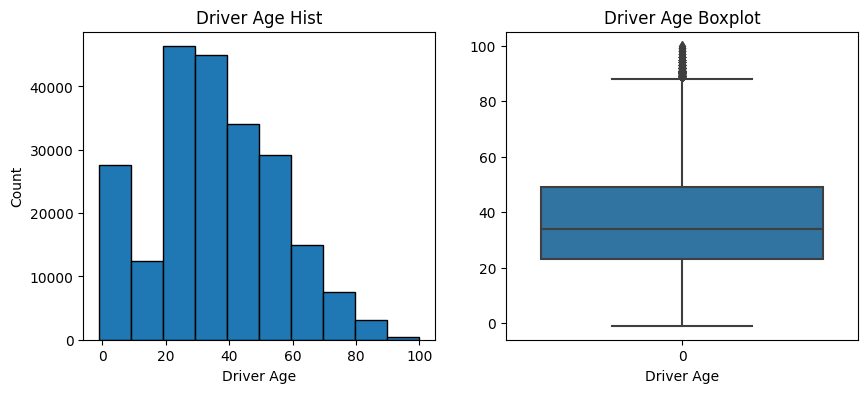

In [17]:
# cleaning 'age_of_driver'
print(f"age_of_driver = {sorted(df['age_of_driver'].unique())}\n")

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(df['age_of_driver'], edgecolor='black')
axs[0].set_title('Driver Age Hist')
axs[0].set_xlabel('Driver Age')
axs[0].set_ylabel('Count')

sns.boxplot(df['age_of_driver'], showfliers=True).set_title('Driver Age Boxplot')
plt.xlabel('Driver Age')

In [18]:
# invalid rows & outliers replaced with median value
#age_median = round((17 + df['age_of_driver'].max()) /2)
age_mean = round(df['age_of_driver'].mean())
df.loc[(df['age_of_driver'] < 17), 'age_of_driver'] = age_mean

In [19]:
df

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,objectid,lsoa01cd,lsoa01nm,lsoa01nmw,shape__area,shape__length,globalid,sex_of_driver_str,sex_of_casualty_str,day_of_week_str
0,2020010219808,2020,010219808,521389.0,175144.0,-0.254001,51.462262,1,3,1,...,4576.0,E01004576,Wandsworth 013D,Wandsworth 013D,445625.061623,4486.701130,c7ddebfb-d730-4be6-b67e-938adb21309e,Female,Male,Wednesday
1,2020010220496,2020,010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,...,3034.0,E01003034,Lambeth 012A,Lambeth 012A,114698.446686,1719.140860,cb2e7f50-252f-469e-9b13-a56794f5d5d6,Male,Female,Tuesday
2,2020010220496,2020,010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,...,3034.0,E01003034,Lambeth 012A,Lambeth 012A,114698.446686,1719.140860,cb2e7f50-252f-469e-9b13-a56794f5d5d6,Male,Female,Tuesday
3,2020010228005,2020,010228005,526432.0,182761.0,-0.178719,51.529614,1,3,1,...,4726.0,E01004726,Westminster 003C,Westminster 003C,185726.854301,2698.692831,e5cccc5e-7d0c-4f89-82c3-2a5d03b1ae18,None,Male,Thursday
4,2020010228006,2020,010228006,538676.0,184371.0,-0.001683,51.541210,1,2,1,...,3617.0,E01003617,Newham 012B,Newham 012B,232690.613373,3013.438191,3e1979c9-8863-4982-afa5-7a6de00635d7,Male,Male,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220430,2020991030297,2020,991030297,383664.0,810646.0,-2.271903,57.186317,99,2,2,...,NaN,None,None,None,NaN,NaN,None,Male,Male,Thursday
220431,2020991030297,2020,991030297,383664.0,810646.0,-2.271903,57.186317,99,2,2,...,NaN,None,None,None,NaN,NaN,None,Male,Male,Thursday
220432,2020991030900,2020,991030900,277161.0,674852.0,-3.968753,55.950940,99,3,2,...,NaN,None,None,None,NaN,NaN,None,Female,Male,Wednesday
220433,2020991030900,2020,991030900,277161.0,674852.0,-3.968753,55.950940,99,3,2,...,NaN,None,None,None,NaN,NaN,None,Male,Male,Wednesday


In [20]:
# 'sex_of_driver',  1, 2
print(f"sex_of_driver = {sorted(df['sex_of_driver'].unique())}\n")
data_processor.clean_categorical_columns(df,'sex_of_driver', [-1, 3])

sex_of_driver = [-1, 1, 2, 3]

   sex_of_driver  Counts
0             -1      15
1              1  140652
2              2   57385
3              3   22349

Mode value = 1

Result After Cleaning
   sex_of_driver  Counts
0              1  163016
1              2   57385


In [21]:
# 'journey_purpose_of_driver',  1, 2, 3, 4, 5, 6
print(f"journey_purpose_of_driver = {sorted(df['journey_purpose_of_driver'].unique())}\n")

journey_purpose_of_driver = [-1, 1, 2, 3, 4, 5, 6]



In [22]:
# 'vehicle_left_hand_drive',  1, 2
print(f"vehicle_left_hand_drive = {sorted(df['vehicle_left_hand_drive'].unique())}\n")
data_processor.clean_categorical_columns(df,'vehicle_left_hand_drive', [-1, 9])

vehicle_left_hand_drive = [-1, 1, 2, 9]

   vehicle_left_hand_drive  Counts
0                       -1     910
1                        1  207019
2                        2    1750
3                        9   10722

Mode value = 1

Result After Cleaning
   vehicle_left_hand_drive  Counts
0                        1  218651
1                        2    1750


In [23]:
# 'first_point_of_impact',  0, 1, 2, 4
print(f"first_point_of_impact = {sorted(df['first_point_of_impact'].unique())}\n")
data_processor.clean_categorical_columns(df,'first_point_of_impact', [-1, 9])

first_point_of_impact = [-1, 0, 1, 2, 3, 4, 9]

   first_point_of_impact  Counts
0                     -1    1140
1                      0   11519
2                      1  110772
3                      2   36808
4                      3   29115
5                      4   24760
6                      9    6287

Mode value = 1

Result After Cleaning
   first_point_of_impact  Counts
0                      0   11519
1                      1  118199
2                      2   36808
3                      3   29115
4                      4   24760


In [24]:
# 'hit_object_off_carriageway',  0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12
print(f"hit_object_off_carriageway = {sorted(df['hit_object_off_carriageway'].unique())}\n")
data_processor.clean_categorical_columns(df,'hit_object_off_carriageway', [-1, 99])

hit_object_off_carriageway = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 99]

    hit_object_off_carriageway  Counts
0                           -1       5
1                            0  191190
2                            1    1476
3                            2    1226
4                            3     454
5                            4    2822
6                            5     102
7                            6     867
8                            7     974
9                            8      25
10                           9    1438
11                          10    2576
12                          11    3204
13                          99   14042

Mode value = 0

Result After Cleaning
    hit_object_off_carriageway  Counts
0                            0  205237
1                            1    1476
2                            2    1226
3                            3     454
4                            4    2822
5                            5     102
6                         

In [25]:
# 'vehicle_leaving_carriageway',  0, 1, 2, 3, 4, 5, 6, 7, 8
print(f"vehicle_leaving_carriageway = {sorted(df['vehicle_leaving_carriageway'].unique())}\n")
data_processor.clean_categorical_columns(df, 'vehicle_leaving_carriageway', [-1, 9])

vehicle_leaving_carriageway = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    vehicle_leaving_carriageway  Counts
0                            -1     798
1                             0  180165
2                             1   13441
3                             2    1665
4                             3    1197
5                             4     797
6                             5     518
7                             6     255
8                             7    6965
9                             8     893
10                            9   13707

Mode value = 0

Result After Cleaning
   vehicle_leaving_carriageway  Counts
0                            0  194670
1                            1   13441
2                            2    1665
3                            3    1197
4                            4     797
5                            5     518
6                            6     255
7                            7    6965
8                            8     893


In [26]:
# 'hit_object_in_carriageway',  0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12
print(f"hit_object_in_carriageway = {sorted(df['hit_object_in_carriageway'].unique())}\n")
data_processor.clean_categorical_columns(df,'hit_object_in_carriageway', [-1, 99])

hit_object_in_carriageway = [-1, 0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 99]

    hit_object_in_carriageway  Counts
0                          -1     780
1                           0  194089
2                           1     199
3                           2     155
4                           4    4238
5                           5      66
6                           6     182
7                           7    1262
8                           8     288
9                           9     296
10                         10    3604
11                         11    1055
12                         12     260
13                         99   13927

Mode value = 0

Result After Cleaning
    hit_object_in_carriageway  Counts
0                           0  208796
1                           1     199
2                           2     155
3                           4    4238
4                           5      66
5                           6     182
6                           7    1262
7         

In [27]:
# 'skidding_and_overturning',  0, 1, 2, 3, 4, 5
print(f"skidding_and_overturning = {sorted(df['skidding_and_overturning'].unique())}\n")
data_processor.clean_categorical_columns(df,'skidding_and_overturning', [-1, 9])

skidding_and_overturning = [-1, 0, 1, 2, 3, 4, 5, 9]

   skidding_and_overturning  Counts
0                        -1     815
1                         0  181068
2                         1   14733
3                         2    3836
4                         3      66
5                         4      34
6                         5    5494
7                         9   14355

Mode value = 0

Result After Cleaning
   skidding_and_overturning  Counts
0                         0  196238
1                         1   14733
2                         2    3836
3                         3      66
4                         4      34
5                         5    5494


In [28]:
# 'junction_location',  0, 1, 2, 3, 4, 5, 6, 7, 8
print(f"junction_location = {sorted(df['junction_location'].unique())}\n")
data_processor.clean_categorical_columns(df,'junction_location', [-1, 9])

junction_location = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    junction_location  Counts
0                  -1     369
1                   0   92971
2                   1   47969
3                   2   11468
4                   3    3264
5                   4    6238
6                   5    4806
7                   6    8713
8                   7     716
9                   8   33676
10                  9   10211

Mode value = 0

Result After Cleaning
   junction_location  Counts
0                  0  103551
1                  1   47969
2                  2   11468
3                  3    3264
4                  4    6238
5                  5    4806
6                  6    8713
7                  7     716
8                  8   33676


In [29]:
# 'vehicle_location_restricted_lane',  0, 1, 2, 3, 4, 5, 6, 7, 8, 9
print(f"vehicle_location_restricted_lane = {sorted(df['vehicle_location_restricted_lane'].unique())}\n")
data_processor.clean_categorical_columns(df,'vehicle_location_restricted_lane', [-1, 99])

vehicle_location_restricted_lane = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 99]

    vehicle_location_restricted_lane  Counts
0                                 -1     773
1                                  0  199512
2                                  1     173
3                                  2     846
4                                  3      73
5                                  4     742
6                                  5     360
7                                  6     840
8                                  7     156
9                                  8     303
10                                 9    3003
11                                99   13620

Mode value = 0

Result After Cleaning
   vehicle_location_restricted_lane  Counts
0                                 0  213905
1                                 1     173
2                                 2     846
3                                 3      73
4                                 4     742
5                                 5  

In [30]:
# 'vehicle_direction_to'
print(f"vehicle_direction_to = {sorted(df['vehicle_direction_to'].unique())}\n")
data_processor.clean_categorical_columns(df,'vehicle_direction_to', [-1])

vehicle_direction_to = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    vehicle_direction_to  Counts
0                     -1    1965
1                      0    8939
2                      1   31112
3                      2   19448
4                      3   29385
5                      4   17833
6                      5   32419
7                      6   18105
8                      7   29538
9                      8   17366
10                     9   14291

Mode value = 5

Result After Cleaning
   vehicle_direction_to  Counts
0                     0    8939
1                     1   31112
2                     2   19448
3                     3   29385
4                     4   17833
5                     5   34384
6                     6   18105
7                     7   29538
8                     8   17366
9                     9   14291


In [31]:
# 'vehicle_direction_from'
print(f"vehicle_direction_from = {sorted(df['vehicle_direction_from'].unique())}\n")
data_processor.clean_categorical_columns(df,'vehicle_direction_from', [-1])

vehicle_direction_from = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    vehicle_direction_from  Counts
0                       -1    1948
1                        0    9214
2                        1   33990
3                        2   18419
4                        3   29636
5                        4   17109
6                        5   31342
7                        6   18327
8                        7   28723
9                        8   17402
10                       9   14291

Mode value = 1

Result After Cleaning
   vehicle_direction_from  Counts
0                       0    9214
1                       1   35938
2                       2   18419
3                       3   29636
4                       4   17109
5                       5   31342
6                       6   18327
7                       7   28723
8                       8   17402
9                       9   14291


In [32]:
# 'vehicle_manoeuvre', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
print(f"vehicle_manoeuvre = {sorted(df['vehicle_manoeuvre'].unique())}\n")
data_processor.clean_categorical_columns(df,'vehicle_manoeuvre', [-1,99])

vehicle_manoeuvre = [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 99]

    vehicle_manoeuvre  Counts
0                  -1     831
1                   1    2381
2                   2    9488
3                   3   10040
4                   4   12934
5                   5    9133
6                   6    1557
7                   7    6633
8                   8     951
9                   9   18949
10                 10    3185
11                 11    1532
12                 12    1753
13                 13    4041
14                 14    1675
15                 15    1371
16                 16    6860
17                 17    7762
18                 18  105183
19                 99   14142

Mode value = 18

Result After Cleaning
    vehicle_manoeuvre  Counts
0                   1    2381
1                   2    9488
2                   3   10040
3                   4   12934
4                   5    9133
5                   6    1557
6                   7    66

In [33]:
# 'towing_and_articulation', 0,1,2,3,4,5
print(f"towing_and_articulation = {sorted(df['towing_and_articulation'].unique())}\n")
data_processor.clean_categorical_columns(df,'towing_and_articulation', [-1,9])

towing_and_articulation = [-1, 0, 1, 2, 3, 4, 5, 9]

   towing_and_articulation  Counts
0                       -1     816
1                        0  212581
2                        1    1800
3                        2      27
4                        3     117
5                        4     815
6                        5     303
7                        9    3942

Mode value = 0

Result After Cleaning
   towing_and_articulation  Counts
0                        0  217339
1                        1    1800
2                        2      27
3                        3     117
4                        4     815
5                        5     303


In [34]:
# 'vehicle_type'
print(f"vehicle_type = {sorted(df['vehicle_type'].unique())}\n")

vehicle_type = [1, 2, 3, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 90, 97, 98]



In [35]:
# 'casualty_imd_decile'
print(f"casualty_imd_decile = {sorted(df['casualty_imd_decile'].unique())}\n")
data_processor.clean_categorical_columns(df,'casualty_imd_decile', [-1])

casualty_imd_decile = [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    casualty_imd_decile  Counts
0                    -1   20559
1                     1   24265
2                     2   25680
3                     3   24373
4                     4   22110
5                     5   20875
6                     6   19529
7                     7   17740
8                     8   16219
9                     9   15695
10                   10   13356

Mode value = 2

Result After Cleaning
   casualty_imd_decile  Counts
0                    1   24265
1                    2   46239
2                    3   24373
3                    4   22110
4                    5   20875
5                    6   19529
6                    7   17740
7                    8   16219
8                    9   15695
9                   10   13356


In [36]:
# 'casualty_home_area_type', it can be 1,2,3
print(f"casualty_home_area_type = {sorted(df['casualty_home_area_type'].unique())}\n")
data_processor.clean_categorical_columns(df,'casualty_home_area_type', [-1])

casualty_home_area_type = [-1, 1, 2, 3]

   casualty_home_area_type  Counts
0                       -1   20270
1                        1  162830
2                        2   16698
3                        3   20603

Mode value = 1

Result After Cleaning
   casualty_home_area_type  Counts
0                        1  183100
1                        2   16698
2                        3   20603


In [37]:
# 'pedestrian_road_maintenance_worker', it can be 0,1,2
print(f"pedestrian_road_maintenance_worker = {sorted(df['pedestrian_road_maintenance_worker'].unique())}\n")
data_processor.clean_categorical_columns(df,'pedestrian_road_maintenance_worker', [-1])

pedestrian_road_maintenance_worker = [-1, 0, 1, 2]

   pedestrian_road_maintenance_worker  Counts
0                                  -1     103
1                                   0  219401
2                                   1      87
3                                   2     810

Mode value = 0

Result After Cleaning
   pedestrian_road_maintenance_worker  Counts
0                                   0  219504
1                                   1      87
2                                   2     810


In [38]:
# 'bus_or_coach_passenger', it can be 0,1,2,3,4
print(f"bus_or_coach_passenger = {sorted(df['bus_or_coach_passenger'].unique())}\n")
data_processor.clean_categorical_columns(df,'bus_or_coach_passenger', [-1, 9])

bus_or_coach_passenger = [-1, 0, 1, 2, 3, 4, 9]

   bus_or_coach_passenger  Counts
0                      -1      34
1                       0  218459
2                       1      57
3                       2      85
4                       3     435
5                       4    1317
6                       9      14

Mode value = 0

Result After Cleaning
   bus_or_coach_passenger  Counts
0                       0  218507
1                       1      57
2                       2      85
3                       3     435
4                       4    1317


In [39]:
# 'car_passenger', it can be 0,1,2
print(f"car_passenger = {sorted(df['car_passenger'].unique())}\n")
data_processor.clean_categorical_columns(df,'car_passenger', [-1, 9])

car_passenger = [-1, 0, 1, 2, 9]

   car_passenger  Counts
0             -1     631
1              0  181879
2              1   24653
3              2   13031
4              9     207

Mode value = 0

Result After Cleaning
   car_passenger  Counts
0              0  182717
1              1   24653
2              2   13031


In [40]:
# 'pedestrian_movement', it can be 1,2,3,4,5,6,7,8,9
print(f"pedestrian_movement = {sorted(df['pedestrian_movement'].unique())}\n")
data_processor.clean_categorical_columns(df,'pedestrian_movement', [-1, 0])

pedestrian_movement = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    pedestrian_movement  Counts
0                    -1       2
1                     0  204389
2                     1    4719
3                     2     791
4                     3    3178
5                     4     600
6                     5    1024
7                     6     131
8                     7     375
9                     8     442
10                    9    4750

Mode value = 0

Result After Cleaning
   pedestrian_movement  Counts
0                    0  204391
1                    1    4719
2                    2     791
3                    3    3178
4                    4     600
5                    5    1024
6                    6     131
7                    7     375
8                    8     442
9                    9    4750


In [41]:
# 'casualty_severity', it can be 1,2,3
print(f"casualty_severity = {sorted(df['casualty_severity'].unique())}\n")

casualty_severity = [1, 2, 3]



age_of_casualty = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]



Text(0.5, 0, 'Casualty Age')

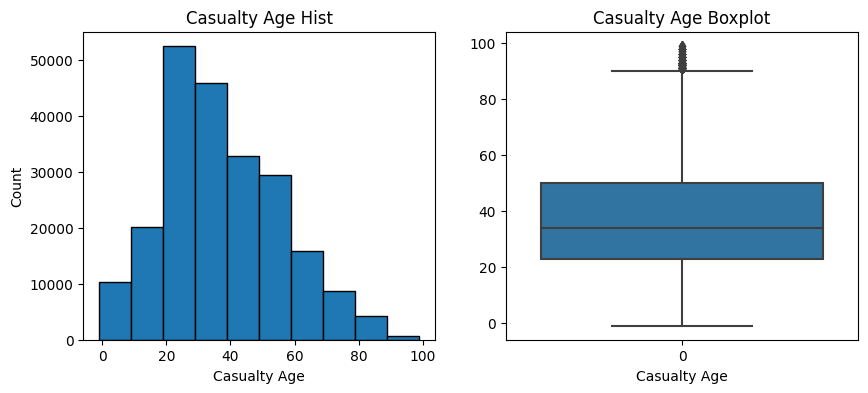

In [42]:
# cleaning 'age_of_casualty'
print(f"age_of_casualty = {sorted(df['age_of_casualty'].unique())}\n")

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(df['age_of_casualty'], edgecolor='black')
axs[0].set_title('Casualty Age Hist')
axs[0].set_xlabel('Casualty Age')
axs[0].set_ylabel('Count')

sns.boxplot(df['age_of_casualty'], showfliers=True).set_title('Casualty Age Boxplot')
plt.xlabel('Casualty Age')

In [43]:
# invalid rows & outliers replaced with mean value
age_mean = round(df['age_of_casualty'].mean())
df.loc[(df['age_of_casualty'] < 0), 'age_of_casualty'] = age_mean

age_of_vehicle = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 66, 67, 68, 78, 84, 86, 88, 92, 93, 96]



Text(0.5, 0, 'Vehicle Age')

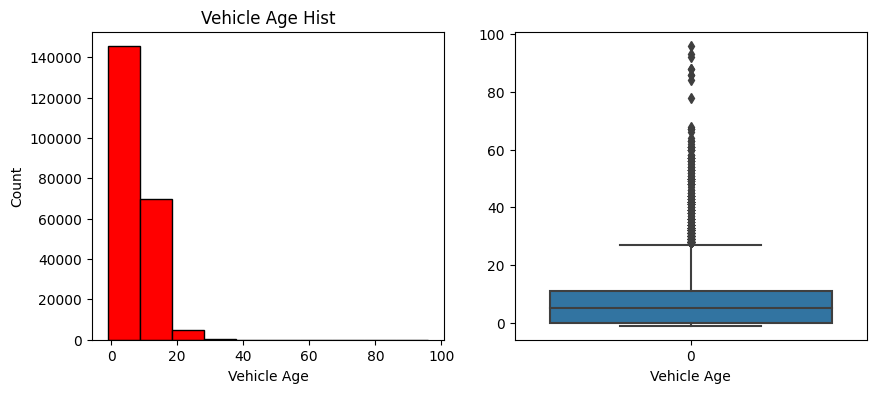

In [44]:
# cleaning 'age_of_vehicle'
print(f"age_of_vehicle = {sorted(df['age_of_vehicle'].unique())}\n")

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(df['age_of_vehicle'], color='red', edgecolor='black')
axs[0].set_title('Vehicle Age Hist')
axs[0].set_xlabel('Vehicle Age')
axs[0].set_ylabel('Count')

sns.boxplot(df['age_of_vehicle'], showfliers=True)
plt.xlabel('Vehicle Age')

In [45]:
# invalid rows & outliers replaced with mean value
age_mean_vehicle = round(df['age_of_vehicle'].mean())
df.loc[(df['age_of_vehicle'] < 0) | (df['age_of_vehicle'] > 40), 'age_of_vehicle'] = age_mean_vehicle

In [46]:
# cleaning 'sex_of_casualty', it can be 1,2
print(f"sex_of_casualty = {sorted(df['sex_of_casualty'].unique())}\n")
data_processor.clean_categorical_columns(df,'sex_of_casualty', [-1, 9])

sex_of_casualty = [-1, 1, 2, 9]

   sex_of_casualty  Counts
0               -1    1393
1                1  137890
2                2   81109
3                9       9

Mode value = 1

Result After Cleaning
   sex_of_casualty  Counts
0                1  139292
1                2   81109


In [47]:
# 'casualty_class', it can be 1,2,3
print(f"casualty_class = {sorted(df['casualty_class'].unique())}\n")

casualty_class = [1, 2, 3]



In [48]:
# cleaning 'lsoa_of_accident_location' ?????????????
print(f"lsoa_of_accident_location = {df['lsoa_of_accident_location'].unique()}\n")

df.groupby('lsoa_of_accident_location').size()
print(df.groupby('lsoa_of_accident_location').size().reset_index(name='Counts'))

lsoa_of_accident_location = ['E01004576' 'E01003034' 'E01004726' ... 'W01000465' 'W01000466'
 'W01000481']

      lsoa_of_accident_location  Counts
0                            -1    8967
1                     E01000001      13
2                     E01000002       2
3                     E01000005      18
4                     E01000006       4
...                         ...     ...
25926                 W01001952      12
25927                 W01001953       2
25928                 W01001955      24
25929                 W01001956       1
25930                 W01001957       3

[25931 rows x 2 columns]


In [49]:
# cleaning 'did_police_officer_attend_scene_of_accident', it can be 1,2
print(f"did_police_officer_attend_scene_of_accident = {sorted(df['did_police_officer_attend_scene_of_accident'].unique())}\n")
data_processor.clean_categorical_columns(df,'did_police_officer_attend_scene_of_accident', [-1, 3])

did_police_officer_attend_scene_of_accident = [-1, 1, 2, 3]

   did_police_officer_attend_scene_of_accident  Counts
0                                           -1       1
1                                            1  158721
2                                            2   42908
3                                            3   18771

Mode value = 1

Result After Cleaning
   did_police_officer_attend_scene_of_accident  Counts
0                                            1  177493
1                                            2   42908


In [50]:
# cleaning 'carriageway_hazards', it can be 0,1,2,3,6,7
print(f"carriageway_hazards = {sorted(df['carriageway_hazards'].unique())}\n")
data_processor.clean_categorical_columns(df,'carriageway_hazards', [-1, 9])

carriageway_hazards = [-1, 0, 1, 2, 3, 6, 7, 9]

   carriageway_hazards  Counts
0                   -1     469
1                    0  213097
2                    1     541
3                    2    2482
4                    3     720
5                    6     284
6                    7     554
7                    9    2254

Mode value = 0

Result After Cleaning
   carriageway_hazards  Counts
0                    0  215820
1                    1     541
2                    2    2482
3                    3     720
4                    6     284
5                    7     554


In [51]:
# cleaning 'special_conditions_at_site', it can be 0,1,2,3,4,5,6,7
print(f"special_conditions_at_site = {sorted(df['special_conditions_at_site'].unique())}\n")
data_processor.clean_categorical_columns(df,'special_conditions_at_site', [-1, 9])

special_conditions_at_site = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 9]

   special_conditions_at_site  Counts
0                          -1     488
1                           0  211646
2                           1     548
3                           2     114
4                           3     393
5                           4    3094
6                           5     409
7                           6     292
8                           7     633
9                           9    2784

Mode value = 0

Result After Cleaning
   special_conditions_at_site  Counts
0                           0  214918
1                           1     548
2                           2     114
3                           3     393
4                           4    3094
5                           5     409
6                           6     292
7                           7     633


In [52]:
# cleaning 'road_surface_conditions', it can be 1,2,3,4,5
print(f"Road Condition = {df['road_surface_conditions'].unique()}\n")

df.groupby('road_surface_conditions').size()
print(df.groupby('road_surface_conditions').size().reset_index(name='Counts'))

df[df['road_surface_conditions'].isin([-1, 9])]

# replace values -1, 9 according to the weather condition
# if weather_conditions = 1,4 then road_surface_conditions = 1
# if weather_conditions = 2,5,7 then road_surface_conditions = 2
# if weather_conditions = 3,6 then road_surface_conditions = 3
# if weather_conditions = 8,9 then road_surface_conditions = 6 (New value for showing Unknown)

df.loc[(df['road_surface_conditions'].isin([-1, 9])) & (df['weather_conditions'].isin([1, 4])), 'road_surface_conditions'] = 1
df.loc[(df['road_surface_conditions'].isin([-1, 9])) & (df['weather_conditions'].isin([2, 5, 7])), 'road_surface_conditions'] = 2
df.loc[(df['road_surface_conditions'].isin([-1, 9])) & (df['weather_conditions'].isin([3, 6])), 'road_surface_conditions'] = 3
df.loc[(df['road_surface_conditions'].isin([-1, 9])) & (df['weather_conditions'].isin([8, 9])), 'road_surface_conditions'] = 6

print("\n Result After Cleaning")
df.groupby('road_surface_conditions').size()
print(df.groupby('road_surface_conditions').size().reset_index(name='Counts') )

Road Condition = [ 9  1  2  5  4  3 -1]

   road_surface_conditions  Counts
0                       -1     664
1                        1  151059
2                        2   64663
3                        3     369
4                        4    1653
5                        5     375
6                        9    1618

 Result After Cleaning
   road_surface_conditions  Counts
0                       -1       1
1                        1  151671
2                        2   64807
3                        3     371
4                        4    1653
5                        5     375
6                        6    1523


In [53]:
# cleaning 'weather_conditions', it can be 1,2,3,4,5,6,7,8,9
print(f"weather_conditions = {sorted(df['weather_conditions'].unique())}\n")
data_processor.clean_categorical_columns(df,'weather_conditions', [-1])

weather_conditions = [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9]

   weather_conditions  Counts
0                  -1       1
1                   1  172112
2                   2   27947
3                   3     498
4                   4    3415
5                   5    3974
6                   6     166
7                   7    1304
8                   8    6116
9                   9    4868

Mode value = 1

Result After Cleaning
   weather_conditions  Counts
0                   1  172113
1                   2   27947
2                   3     498
3                   4    3415
4                   5    3974
5                   6     166
6                   7    1304
7                   8    6116
8                   9    4868


In [54]:
# cleaning 'light_conditions'
print(f"light_conditions = {sorted(df['light_conditions'].unique())}\n")
data_processor.clean_categorical_columns(df,'light_conditions', [-1])

light_conditions = [-1, 1, 4, 5, 6, 7]

   light_conditions  Counts
0                -1       1
1                 1  156620
2                 4   45607
3                 5    1529
4                 6   12019
5                 7    4625

Mode value = 1

Result After Cleaning
   light_conditions  Counts
0                 1  156621
1                 4   45607
2                 5    1529
3                 6   12019
4                 7    4625


In [55]:
# cleaning 'speed_limit'
print(f"speed_limit = {sorted(df['speed_limit'].unique())}")
data_processor.clean_categorical_columns(df,'speed_limit', [-1])

speed_limit = [-1, 20, 30, 40, 50, 60, 70]
   speed_limit  Counts
0           -1      14
1           20   22673
2           30  119604
3           40   21158
4           50   11282
5           60   30380
6           70   15290

Mode value = 30

Result After Cleaning
   speed_limit  Counts
0           20   22673
1           30  119618
2           40   21158
3           50   11282
4           60   30380
5           70   15290


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220401 entries, 0 to 220434
Data columns (total 86 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               220401 non-null  object 
 1   accident_year                                220401 non-null  int64  
 2   accident_reference                           220401 non-null  object 
 3   location_easting_osgr                        220401 non-null  float64
 4   location_northing_osgr                       220401 non-null  float64
 5   longitude                                    220401 non-null  float64
 6   latitude                                     220401 non-null  float64
 7   police_force                                 220401 non-null  int64  
 8   accident_severity                            220401 non-null  int64  
 9   number_of_vehicles                           220401 non-nul

In [57]:
df.isnull().sum()

accident_index                0
accident_year                 0
accident_reference            0
location_easting_osgr         0
location_northing_osgr        0
                          ...  
shape__length             18458
globalid                  18458
sex_of_driver_str         22364
sex_of_casualty_str        1402
day_of_week_str               0
Length: 86, dtype: int64

# Exploratory Data Analysis

### Defining a class with needed methods

In [58]:
class ExploratoryDataAnalysis:
    def __init__(self, df):
        self.df = df
        
        # Setting the int values with their related string values
        severity_mapping = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}
        df['accident_severity_label'] = df['accident_severity'].map(severity_mapping)
        
        
        road_type_mapping = {1: 'Roundabout', 2: 'One way street', 3: 'Dual carriageway', 6: 'Single carriageway', 7: 'Slip road', 9: 'Unknown'}
        df['road_type_label'] = df['road_type'].map(road_type_mapping)
        
        
        junction_detail_mapping = {0: 'Not at or within 20 metres of junction', 1: 'Roundabout', 2: 'Mini roundabout', 
                                   3:'T or staggered junction', 5: 'Slip road', 6: 'Crossroads', 7: 'Junction more than four arms (not RAB)', 
                                   8: 'Using private drive or entrance', 9: 'Other junction'}
        df['junction_detail_label'] = df['junction_detail'].map(junction_detail_mapping)
        
        
        light_conditions_mapping = {1: 'Daylight', 4: 'Darkness: street lights present and lit', 5: 'Darkness: street lights present but unlit',
                                    6: 'Darkness: no street lighting', 7: 'Darkness: street lighting unknown'}
        df['light_conditions_label'] = df['light_conditions'].map(light_conditions_mapping)
        
        
        special_conditions_at_site_mapping = {0: 'None', 1: 'Auto traffic signal out', 2: 'Auto traffic signal partially defective', 
                                              3: 'Permanent road signing or marking defective or obscured',
                                              4: 'Roadworks', 5: 'Road surface defective', 6: 'Oil or diesel', 7: 'Mud'}
        df['special_conditions_at_site_label'] = df['special_conditions_at_site'].map(special_conditions_at_site_mapping)
        
        
        road_surface_conditions_mapping = {1: 'Dry', 2: 'Wet / Damp', 3: 'Snow', 4: 'Frost / Ice', 5: 'Flood (surface water over 3cm deep)'}
        df['road_surface_conditions_label'] = df['road_surface_conditions'].map(road_surface_conditions_mapping)
        
        
        weather_conditions_mapping = {1: 'Fine without high winds', 2: 'Raining without high winds', 3: 'Snowing without high winds',
                                      4: 'Fine with high winds', 5: 'Raining with high winds', 6: 'Snowing with high winds',
                                      7: 'Fog or mist — if hazard', 8: 'Other', 9: 'Unknown'}
        df['weather_conditions_label'] = df['weather_conditions'].map(weather_conditions_mapping)
        
        
        urban_or_rural_area_mapping = {1: 'Urban', 2: 'Rural'}
        df['urban_or_rural_area_label'] = df['urban_or_rural_area'].map(urban_or_rural_area_mapping)
        
        
        sex_of_driver_mapping = {1: 'Male', 2: 'Female'}
        df['sex_of_driver_label'] = df['sex_of_driver'].map(sex_of_driver_mapping)
        
        
        sex_of_casualty_mapping = {1: 'Male', 2: 'Female'}
        df['sex_of_casualty_label'] = df['sex_of_casualty'].map(sex_of_casualty_mapping)
        
        
        did_police_officer_attend_scene_of_accident_mapping = {1: 'Yes', 2: 'No'}
        df['did_police_officer_attend_scene_of_accident_label'] = df['did_police_officer_attend_scene_of_accident'].map(did_police_officer_attend_scene_of_accident_mapping)
        
        
        day_of_week_mapping = { 1: 'Monday',
                                2: 'Tuesday',
                                3: 'Wednesday',
                                4: 'Thursday',
                                5: 'Friday',
                                6: 'Saturday',
                                7: 'Sunday'}  
        df['day_of_week_label'] = df['day_of_week'].map(day_of_week_mapping)
        
        
    def plot_by_features(self, data, features):
        '''
            The method plots according to the input data and features (List<feature>)
        '''
        for feature in features:
            
            # Define the colors for each category
            if feature in ('sex_of_driver_label','sex_of_casualty_label'):
                palette = {'Male': '#1f77b4', 'Female': 'red'}
                # Create the countplot with specified palette
                ax = sns.countplot(x=feature, data=data, palette=palette)
            else:
                ax = sns.countplot(x=feature, data=data)
            
            for p in ax.patches:
                ax.annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')            
            
            # delete _label from the end of the feature name
            x_title = feature.replace('_label', '')
            ax.set_xlabel(x_title)
            ax.set_title(f'Number of accidents by {x_title}')
            
            # Rotate and center x-axis labels
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            
            plt.show()
            print('\n')
         
        
    def plot_pie_chart(self, data, features):
        '''
            The function plots Pie Chart according according to the inputs
        '''
        for col in features:
            x = data[col].value_counts().values
            labels = data[col].unique()
            colors = ['red' if label == 'No' else 'green' for label in labels]
            plt.pie(x, center=(0, 0), radius=1.5, labels=labels, colors=colors,
                    autopct='%1.1f%%', pctdistance=0.5, textprops={'fontsize': 14})
            plt.axis('equal')
            plt.show()
            
    
    def get_age_group(self, group_count):
        '''
            The function creates age groups
        '''
        ages_groups = []
        for i in range(0, group_count):
            #ages_groups.append(str(start) + "-" + str(step))
            if i == 0:
                ages_groups.append(f"{i * 5}-{i * 5 + 5}")
            else:
                ages_groups.append(f"{i * 5 + 1}-{i * 5 + 5}")
        ages_groups.append('Over 75')
        return ages_groups
    
    def create_age_pyramid(self, columns_list, title):
        ages_groups = []
        male_groups = []
        female_groups = []
            
        #create age groups
        ages_groups = self.get_age_group(15)
            
        for item in ages_groups:
            if item == 'Over 75':
                male = self.df[(self.df[columns_list[1]] == 'Male') & (self.df[columns_list[0]] > 75)]
                female = self.df[(self.df[columns_list[1]] == 'Female') & (self.df[columns_list[0]] > 75)]
                male_groups.append(male[columns_list[0]].count() * -1)
                female_groups.append(female[columns_list[0]].count())
                continue
                
            groups = item.split('-')
            male = self.df[(self.df[columns_list[1]] == 'Male') & (self.df[columns_list[0]] > int(groups[0])) & (self.df[columns_list[0]] <= int(groups[1]))]
            female = self.df[(self.df[columns_list[1]] == 'Female') & (self.df[columns_list[0]] > int(groups[0])) & (self.df[columns_list[0]] <= int(groups[1]))]
            male_groups.append(male[columns_list[0]].count() * -1)
            female_groups.append(female[columns_list[0]].count())
            
           
        #create a dataframe with above information
        df_group = pd.DataFrame({'Age': ages_groups, 'Male' : male_groups, 'Female' : female_groups})
        # reverse the the list to show from min to max
        ages_groups.reverse()
        
        # Plot pyramid
        age_pyramid = sns.barplot(x='Male', y='Age', data=df_group, order=ages_groups, color=('#1f77b4'), label='Male')
        age_pyramid = sns.barplot(x='Female', y='Age', data=df_group, order=ages_groups, color=('red'), label='Female')
        age_pyramid.legend()
        plt.title(f'{title} Pyramid')
        age_pyramid.set(xlabel=f'{title} Count', ylabel='Age Group')
    
    
    def create_correlation(self, data, title):
        plt.figure(figsize = (15,10))
        corr = data.corr(method='spearman')
        mask = np.triu(np.ones_like(corr, dtype=bool))
        cormat = sns.heatmap(corr, mask=mask, annot=True, cmap='YlGnBu', linewidths=1, fmt=".2f")
        cormat.set_title('{title} Correlation Matrix')
        plt.show()
        
    def plot_severity_on_map(self, accident_severity):
        severity_df = df[df['accident_severity'] == accident_severity]

        # Create a map centered at the mean latitude and longitude of the filtered data
        map_center = [severity_df['latitude'].mean(), severity_df['longitude'].mean()]
        accident_map = folium.Map(location=map_center, zoom_start=5)
        
        if(accident_severity == 1):
            color = 'red'
        elif(accident_severity == 2):
            color = 'blue'
        elif(accident_severity == 3):
            color = 'green'    

        # Add circle markers for each accident location
        for index, row in severity_df.iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=3,
                color=color,
                fill=True,
                fill_color='white',
                fill_opacity=0.6,
                popup=row['accident_index'],  # You can customize the popup content here
            ).add_to(accident_map)

        return accident_map

In [59]:
eda = ExploratoryDataAnalysis(df)

### Accident Severity

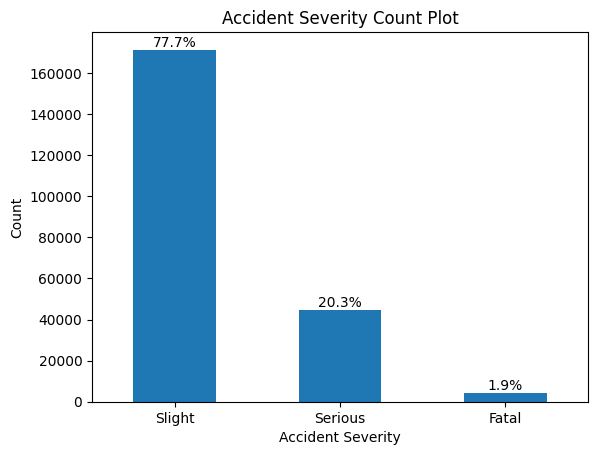

In [60]:
# Plot the count of accident_severity
ax = df['accident_severity_label'].value_counts().plot(kind='bar')

# Customize the tick labels
ax.set_xticklabels(df['accident_severity_label'].unique(), rotation=0)

# Annotate bars with percentage values
total_count = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.xlabel('Accident Severity')
plt.ylabel('Count')
plt.title('Accident Severity Count Plot')
plt.show()

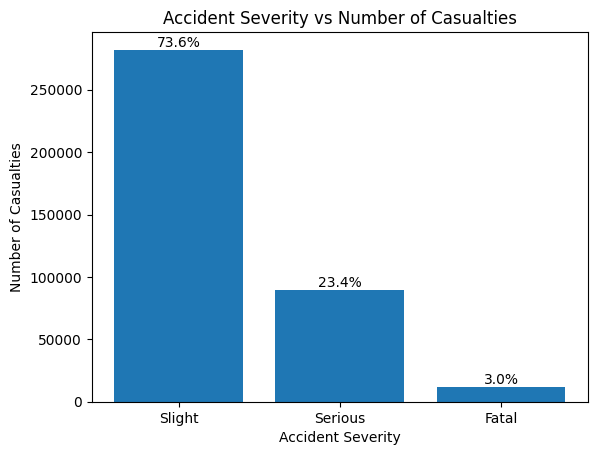

In [61]:
# Plot accident_severity vs number_of_casualties

# Group data by Accident Severity and calculate the total Number of Casualties
severity_casualties = df.groupby('accident_severity_label')['number_of_casualties'].sum().reset_index()
severity_casualties = severity_casualties.sort_values(by='number_of_casualties', ascending=False)

# Plot accident_severity vs number_of_casualties
bars = plt.bar(severity_casualties['accident_severity_label'], severity_casualties['number_of_casualties'])

# Annotate bars with percentage values
total_casualties = severity_casualties['number_of_casualties'].sum()
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height / total_casualties * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Accident Severity')
plt.ylabel('Number of Casualties')
plt.title('Accident Severity vs Number of Casualties')
plt.show()

### Road Features

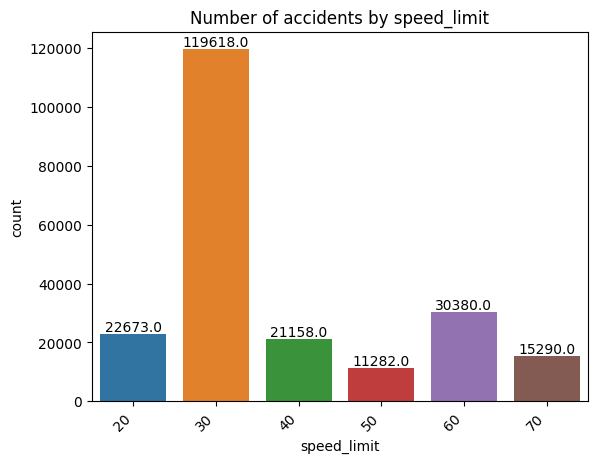

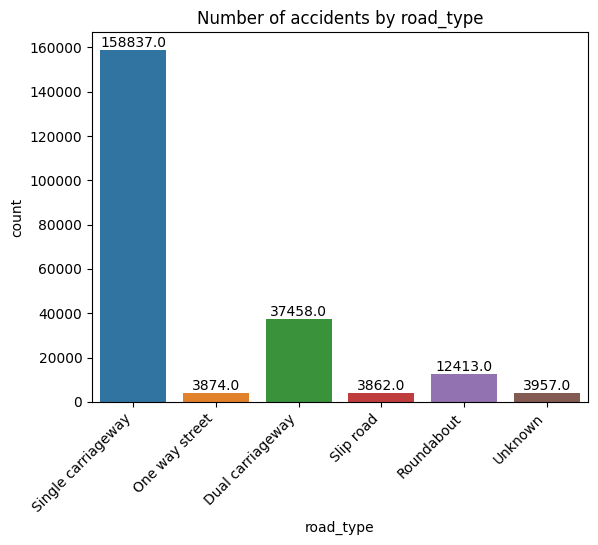

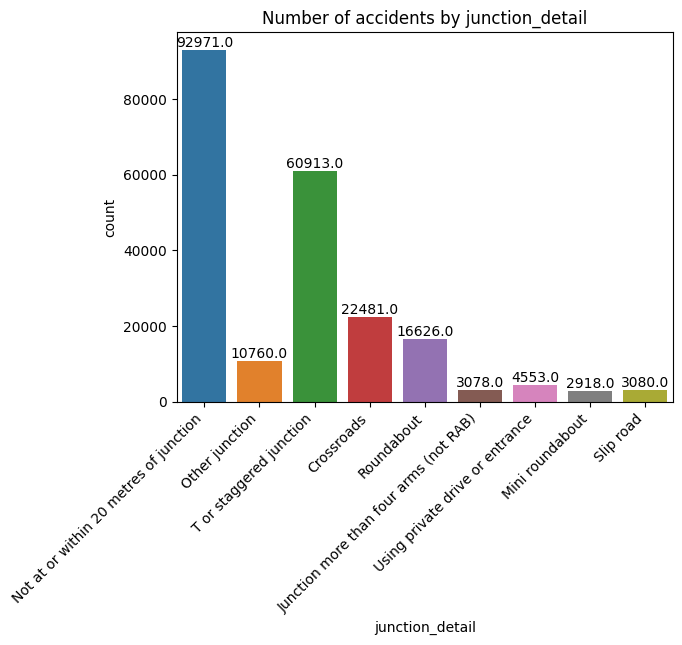

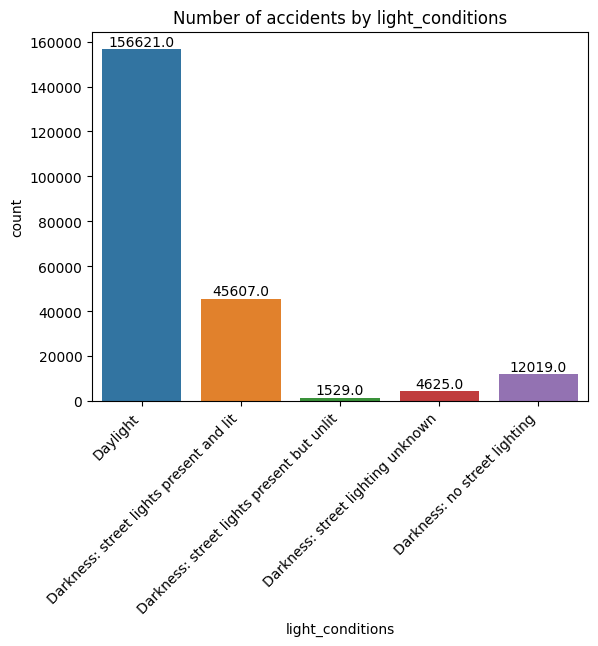

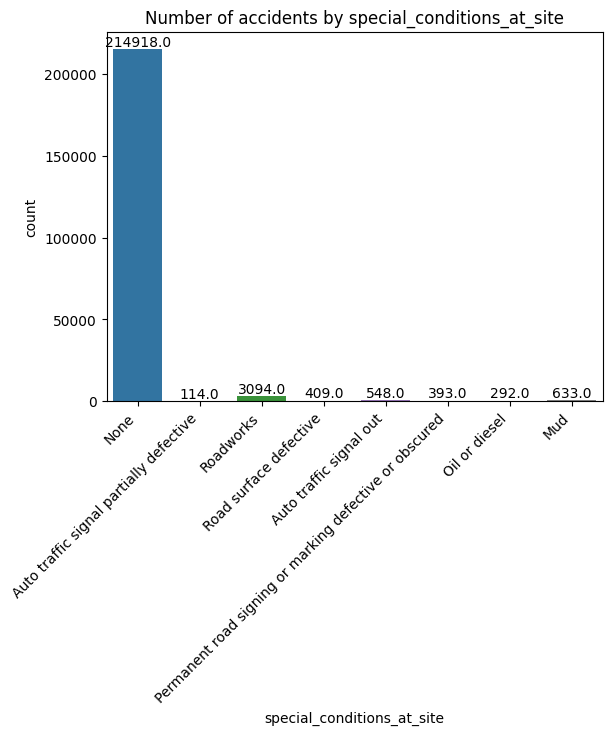

In [62]:
road_features = [
    'speed_limit', 
    'road_type_label', 
    'junction_detail_label',
    #'pedestrian_crossing_physical_facilities', 
    'light_conditions_label',
    'special_conditions_at_site_label']

eda.plot_by_features(df, road_features)

### Weather and Road Surface Conditions

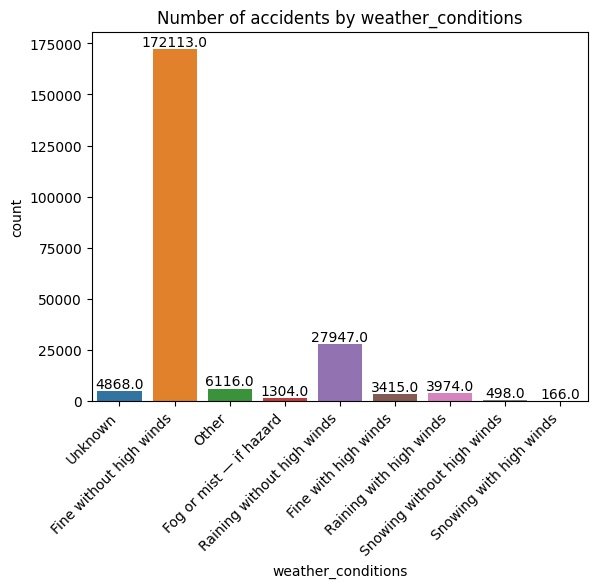

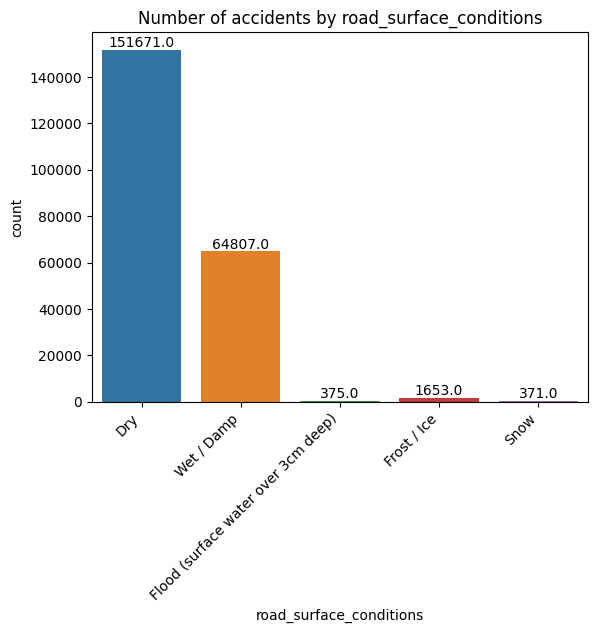

In [63]:
weather_features = [
    'weather_conditions_label',
    'road_surface_conditions_label'
    ]

eda.plot_by_features(df, weather_features)

### Urban and Rural Areas

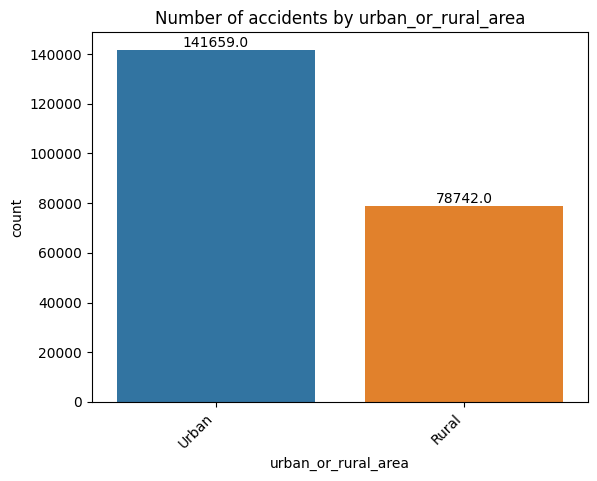

In [64]:
urban_or_rural_area_features = ['urban_or_rural_area_label']
eda.plot_by_features(df, urban_or_rural_area_features)

## Age & Gender

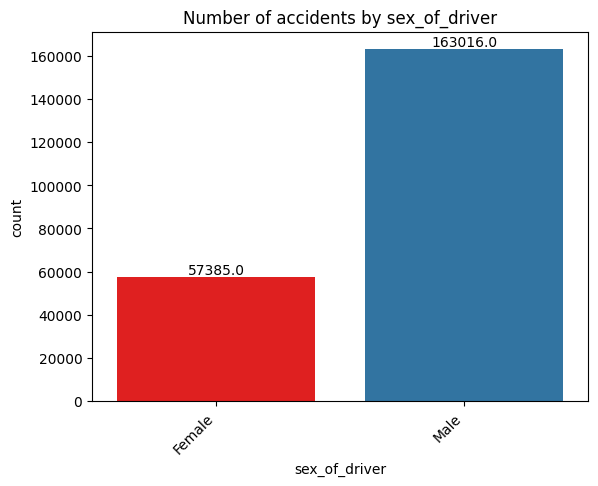

In [65]:
sex_of_driver_features = ['sex_of_driver_label']
eda.plot_by_features(df, sex_of_driver_features)

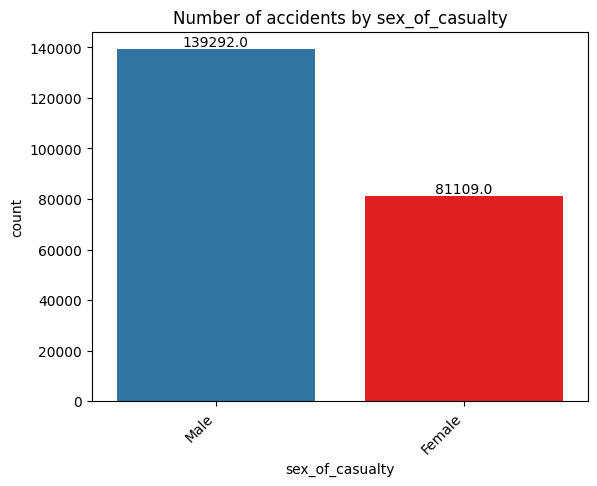

In [66]:
sex_of_casualty_features = ['sex_of_casualty_label']
eda.plot_by_features(df, sex_of_casualty_features)

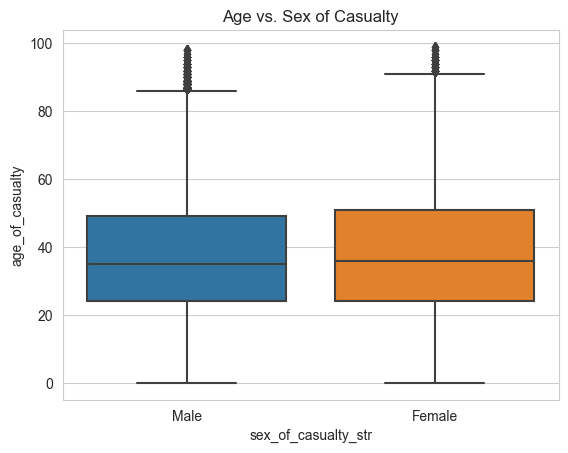

In [67]:
# getting the distribution and outliers by boxplot

fig = plt.figure()
sns.set_style("whitegrid")
plt_box_plot = sns.boxplot(x="sex_of_casualty_str", y="age_of_casualty", data=df)
plt.title('Age vs. Sex of Casualty')
plt.show()

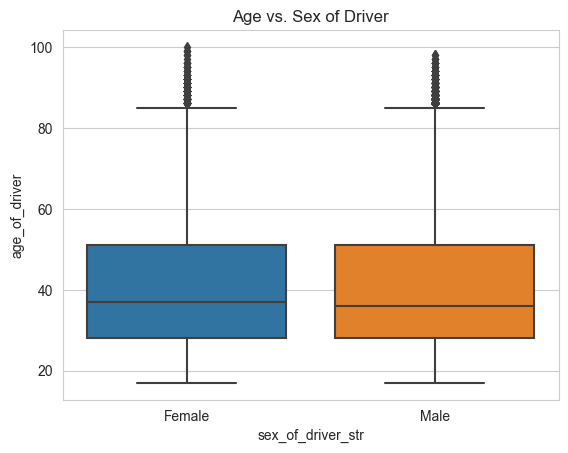

In [68]:
# getting the distribution and outliers by boxplot

fig = plt.figure()
sns.set_style("whitegrid")
plt_box_plot = sns.boxplot(x="sex_of_driver_str", y="age_of_driver", data=df)
plt.title('Age vs. Sex of Driver')
plt.show()

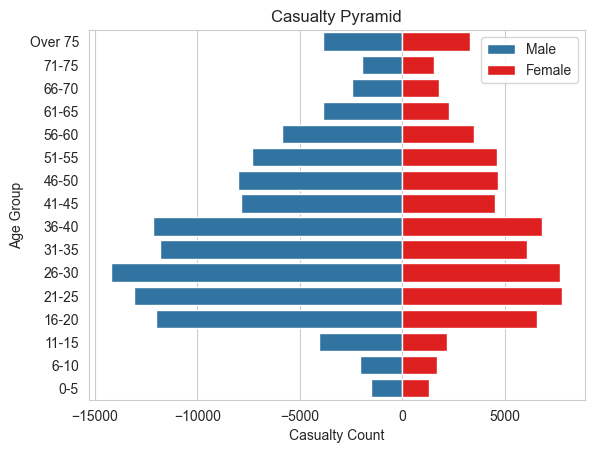

In [69]:
#eda = ExploratoryDataAnalysis(df)
eda.create_age_pyramid(['age_of_casualty', 'sex_of_casualty_str'], 'Casualty')

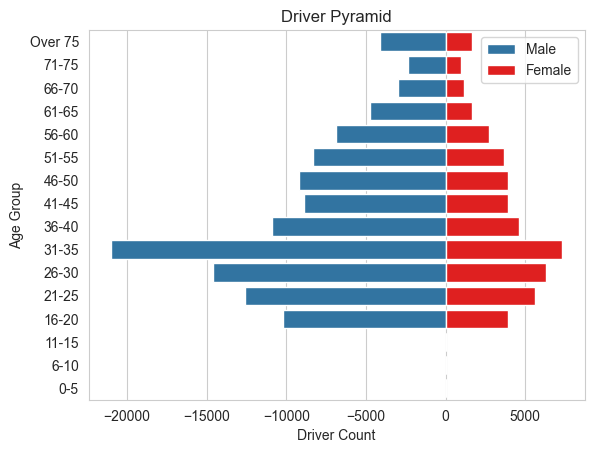

In [70]:
eda.create_age_pyramid(['age_of_driver', 'sex_of_driver_str'], 'Driver')

## Correlation

In [71]:
#def create_correlation(data, title):
#    plt.figure(figsize = (15,10))
#    corr = data.corr(method='spearman')
#    mask = np.triu(np.ones_like(corr, dtype=bool))
#    cormat = sns.heatmap(corr, mask=mask, annot=True, cmap='YlGnBu', linewidths=1, fmt=".2f")
#    cormat.set_title('{title} Correlation Matrix')
#    plt.show()

In [72]:
#eda.create_correlation(df_accident, 'Accident')

In [73]:
#eda.create_correlation(df_vehicle, 'Vehicle')

In [74]:
#eda.create_correlation(df_casualty, 'Casualty')

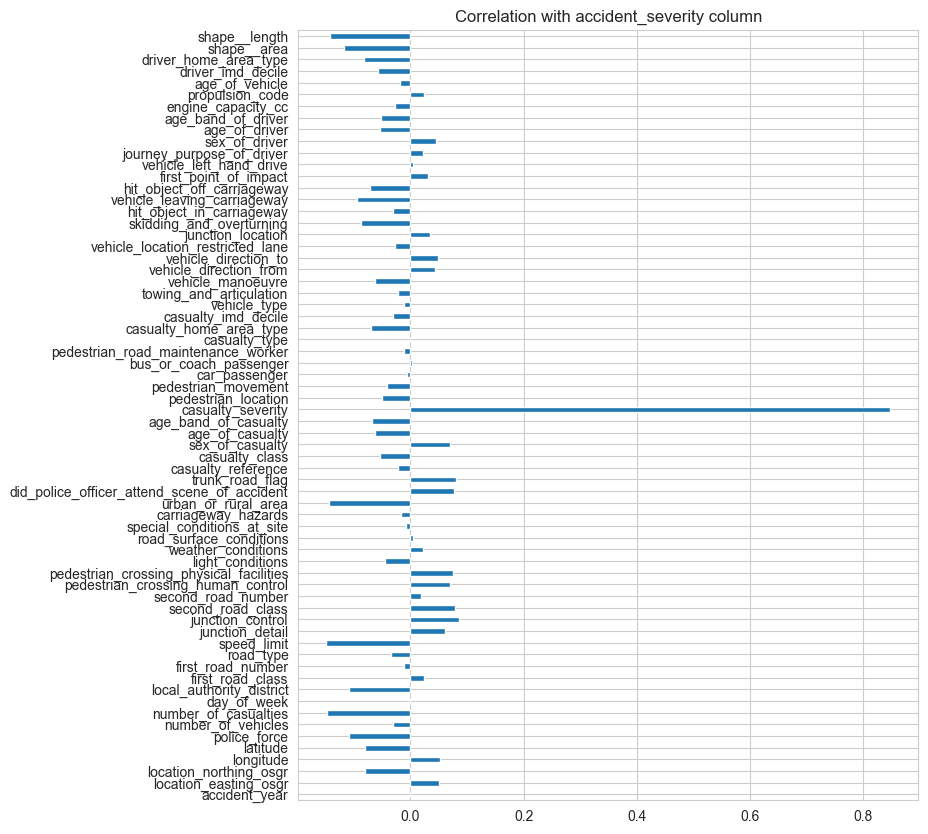

In [75]:
df_correlation = df.drop(columns=['accident_severity', 'accident_index', 'accident_reference', 'vehicle_index', 'vehicle_reference', 'casualty_index', 'objectid'], axis=1)

plt.figure(figsize=(8, 10))
df_correlation.corrwith(df['accident_severity']).plot(kind='barh', title="Correlation with accident_severity column")
plt.show()

## Accident Severity & Casualty

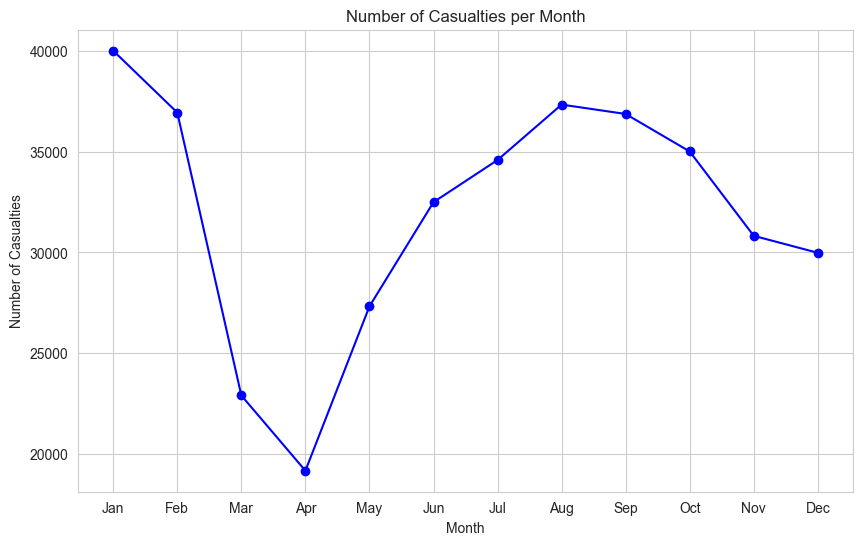

The lowest number of casualties during spring (April and May) is: 19155


In [76]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract month from the 'date' column
df['month'] = df['date'].dt.month

# Group by month to get the count of casualties
casualties_per_month = df.groupby('month')['number_of_casualties'].sum()

# Plot the time series
plt.figure(figsize=(10, 6))
casualties_per_month.plot(marker='o', color='b')
plt.title('Number of Casualties per Month')
plt.xlabel('Month')
plt.ylabel('Number of Casualties')
plt.grid(True)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Find the lowest number of casualties during spring (April and May)
lowest_casualties_spring = casualties_per_month[(casualties_per_month.index == 4) | (casualties_per_month.index == 5)].min()

print("The lowest number of casualties during spring (April and May) is:", lowest_casualties_spring)

In [77]:
sub_df = df[['date','accident_severity']]

# pull out the year
year = sub_df['date'].dt.year
week = sub_df['date'].dt.week

# groupby year and severities
count_of_fatalities = sub_df.set_index('date').groupby([pd.Grouper(freq='W'), 'accident_severity']).size()

# build a table
fatalities_table = count_of_fatalities.rename_axis(['Week', 'accident_severity'])\
                                      .unstack('accident_severity')\
                                      .rename({1:'fatal', 2:'serious', 3:'slight'}, axis='columns')
fatalities_table.head()

accident_severity,fatal,serious,slight
Week,,,
2020-01-05,98,455,1768
2020-01-12,83,854,3695
2020-01-19,58,1115,4752
2020-01-26,128,963,4647
2020-02-02,84,981,4235


In [78]:
fatalities_table['sum'] = fatalities_table.sum(axis=1)
fatalities_table = fatalities_table.join(fatalities_table.div(fatalities_table['sum'], axis=0), rsuffix='_percentage')
fatalities_table.head()

accident_severity,fatal,serious,slight,sum,fatal_percentage,serious_percentage,slight_percentage,sum_percentage
Week,,,,,,,,
2020-01-05,98,455,1768,2321,0.042223,0.196036,0.761741,1.0
2020-01-12,83,854,3695,4632,0.017919,0.184370,0.797712,1.0
2020-01-19,58,1115,4752,5925,0.009789,0.188186,0.802025,1.0
2020-01-26,128,963,4647,5738,0.022307,0.167829,0.809864,1.0
2020-02-02,84,981,4235,5300,0.015849,0.185094,0.799057,1.0


<Figure size 1400x600 with 0 Axes>

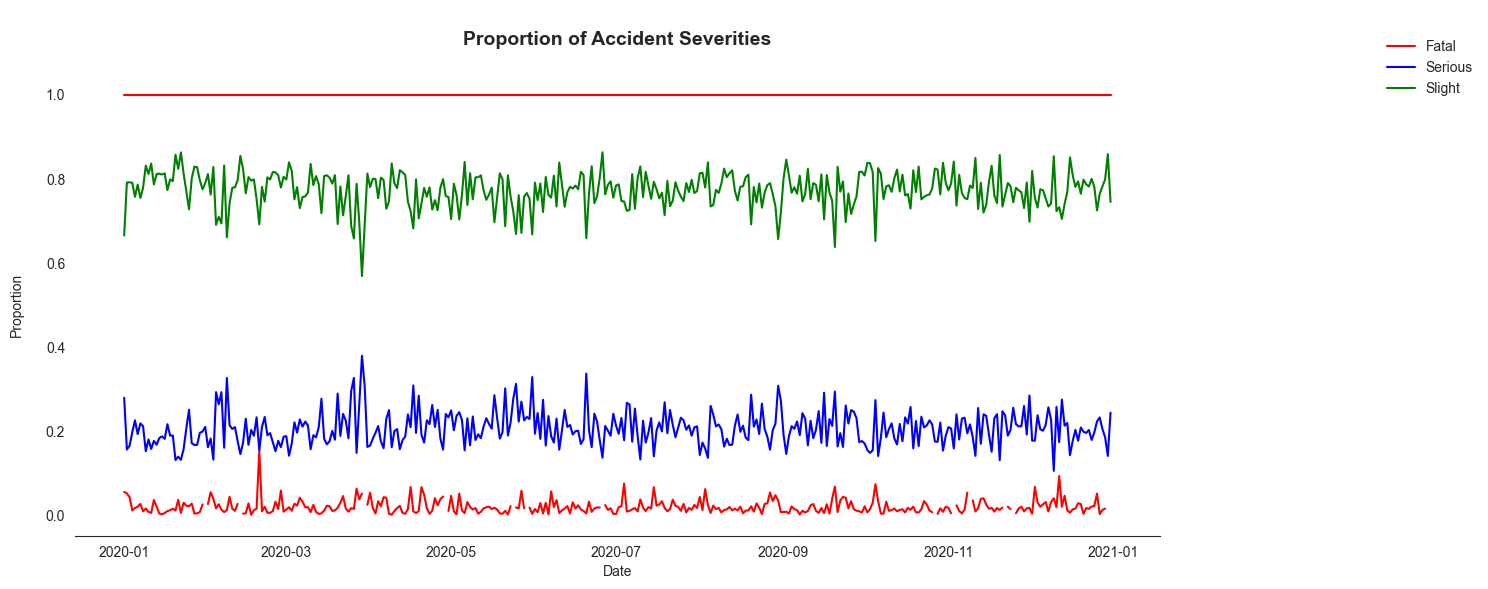

In [79]:
# Group by day and accident severity to get the count
count_of_fatalities = df.groupby([df['date'].dt.date, 'accident_severity']).size()

# Build a nice table
fatalities_table = count_of_fatalities.rename_axis(['Date', 'Accident_Severity']) \
    .unstack('Accident_Severity') \
    .rename({1: 'Fatal', 2: 'Serious', 3: 'Slight'}, axis='columns')
fatalities_table['Total'] = fatalities_table.sum(axis=1)

# Prepare data
sub_df = fatalities_table.div(fatalities_table['Total'], axis=0)

# Create a new figure
plt.figure(figsize=(14, 6))

# Prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(14,6))
colors = ['red', 'blue', 'green']

# Plot
sub_df.plot(color=colors, ax=ax)
ax.set_title('\nProportion of Accident Severities\n', fontsize=14, fontweight='bold')
ax.set(ylabel='Proportion\n', xlabel='Date')

ax.legend(labels=['Fatal', 'Serious', 'Slight'], bbox_to_anchor=(1.3, 1.1), frameon=False)

# Remove all spines
sns.despine(top=True, right=True, left=True, bottom=False)

plt.show()

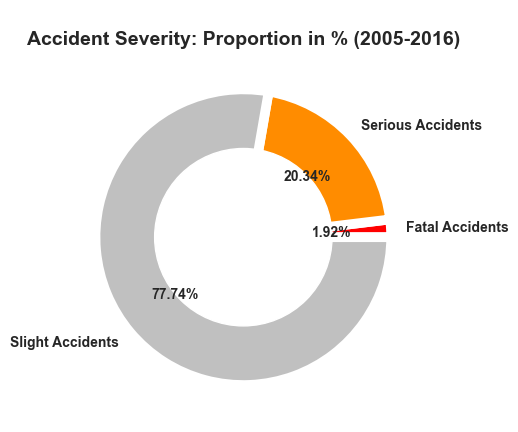

In [80]:
# assign the data
fatal   = df.accident_severity_label.value_counts()['Fatal']
serious = df.accident_severity_label.value_counts()['Serious']
slight  = df.accident_severity_label.value_counts()['Slight']

names = ['Fatal Accidents','Serious Accidents', 'Slight Accidents']
size  = [fatal, serious, slight]

# create a pie chart
plt.pie(x=size, labels=names, colors=['red', 'darkorange', 'silver'], 
        autopct='%1.2f%%', pctdistance=0.6, textprops=dict(fontweight='bold'),
        wedgeprops={'linewidth':7, 'edgecolor':'white'})

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.gca().add_artist(my_circle)
plt.title('\nAccident Severity: Proportion in % (2005-2016)', fontsize=14, fontweight='bold')
plt.show();

### Plotting according to the severity level on the map : The code is commented since the notebook become heavy.

In [81]:
# accident_severity = 1
#eda.plot_severity_on_map(1)

In [82]:
# accident_severity = 2
#eda.plot_severity_on_map(2)

In [83]:
# accident_severity = 3
#eda.plot_severity_on_map(3)

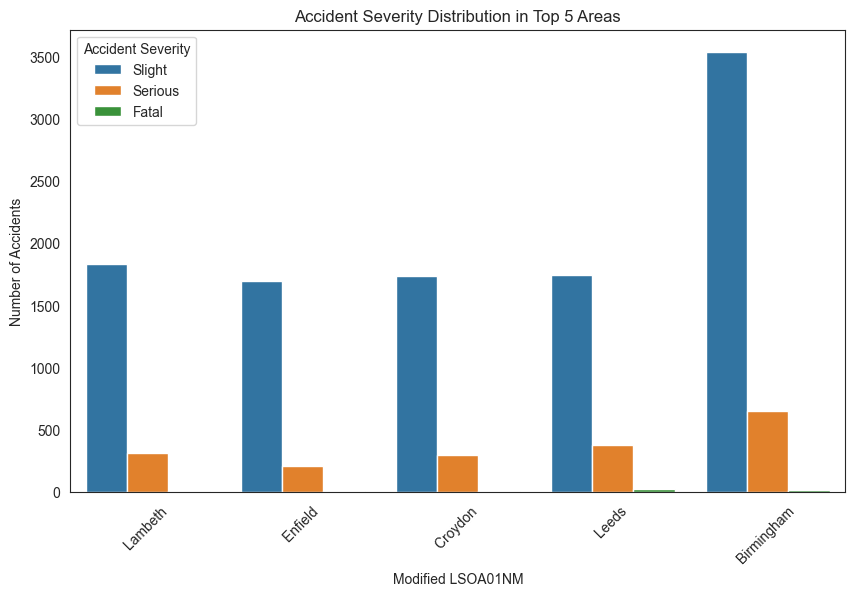

In [84]:
df['modified_lsoa01nm'] = df['lsoa01nm'].str[:-4]

# Group by modified_lsoa01nm and accident_severity to get the count of accidents
severity_counts = df.groupby(['modified_lsoa01nm', 'accident_severity_label']).size()

# Select the top 5 modified_lsoa01nm based on total number of accidents
top_5_areas = severity_counts.groupby('modified_lsoa01nm').sum().nlargest(5).index

# Filter the original DataFrame to include only the top 5 areas
top_5_df = df[df['modified_lsoa01nm'].isin(top_5_areas)]

# Plot the accident severity distribution for each of the top 5 areas
plt.figure(figsize=(10, 6))
sns.countplot(data=top_5_df, x='modified_lsoa01nm', hue='accident_severity_label')
plt.title('Accident Severity Distribution in Top 5 Areas')
plt.xlabel('Modified LSOA01NM')
plt.ylabel('Number of Accidents')
plt.legend(title='Accident Severity')
plt.xticks(rotation=45)
plt.show()

In [85]:
## Group by modified_lsoa01nm and accident_severity to get the count of accidents
#severity_counts = df.groupby(['modified_lsoa01nm', 'accident_severity']).size()
#
## Select the top 5 modified_lsoa01nm based on total number of accidents
#top_5_areas = severity_counts.groupby('modified_lsoa01nm').sum().nlargest(5).index
#
## Filter the original DataFrame to include only the top 5 areas
#top_5_df = df[df['modified_lsoa01nm'].isin(top_5_areas)]
#
## Create a map centered at the mean latitude and longitude of the filtered data
#map_center = [top_5_df['latitude'].mean(), top_5_df['longitude'].mean()]
#accident_map = folium.Map(location=map_center, zoom_start=10)
#
## Add circle markers for each accident location
#for index, row in top_5_df.iterrows():
#    folium.CircleMarker(
#        location=[row['latitude'], row['longitude']],
#        radius=3,
#        color='red',
#        fill=True,
#        fill_color='white',
#        fill_opacity=0.6,
#        popup=f"Severity: {row['accident_severity']}",
#    ).add_to(accident_map)
#
#accident_map

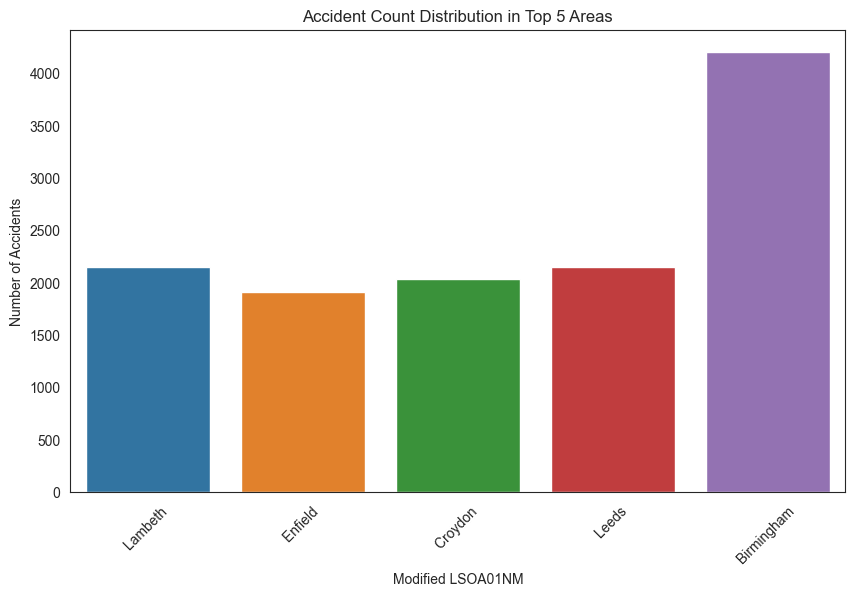

In [86]:
df['modified_lsoa01nm'] = df['lsoa01nm'].str[:-4]

# Group by modified_lsoa01nm to get the count of accidents
accident_counts = df['modified_lsoa01nm'].value_counts()

# Select the top 5 modified_lsoa01nm based on total number of accidents
top_5_areas = accident_counts.nlargest(5).index

# Filter the original DataFrame to include only the top 5 areas
top_5_df = df[df['modified_lsoa01nm'].isin(top_5_areas)]

# Plot the accident count distribution for each of the top 5 areas
plt.figure(figsize=(10, 6))
sns.countplot(data=top_5_df, x='modified_lsoa01nm')
plt.title('Accident Count Distribution in Top 5 Areas')
plt.xlabel('Modified LSOA01NM')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()

In [87]:
#coordinates = df.groupby('modified_lsoa01nm').agg({'latitude': 'mean', 'longitude': 'mean'}).loc[top_5_areas]
#
## Create a map centered at the mean latitude and longitude of the top 5 areas
#map_center = [coordinates['latitude'].mean(), coordinates['longitude'].mean()]
#accident_map = folium.Map(location=map_center, zoom_start=10)
#
## Add circle markers for each area with the number of accidents as the popup
#for area, data in coordinates.iterrows():
#    folium.CircleMarker(
#        location=[data['latitude'], data['longitude']],
#        radius=5,
#        color='red',
#        fill=True,
#        fill_color='red',
#        fill_opacity=0.6,
#        popup=f"{area}: {accident_counts[area]} accidents"
#    ).add_to(accident_map)
#
## Display the map
#accident_map

## Police Attendence

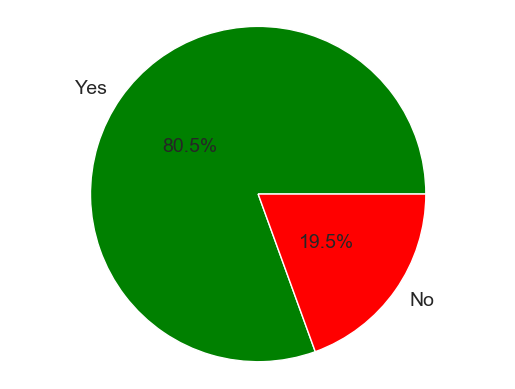

In [88]:
feature_police = ['did_police_officer_attend_scene_of_accident_label']
eda.plot_pie_chart(df, feature_police)

# Analysis Part

### Defining a class with needed methods

In [89]:
class AccidentAnalysis:
    def __init__(self, df):
        self.df = df

    def plot_hourly_and_daily_accidents(self):
        '''
            The function plots the hourly and daily distribution of accidents.
        '''
        
        # Convert 'time' column to datetime format
        self.df['time'] = pd.to_datetime(self.df['time'])

        # Extract hour from 'time' column
        self.df['hour'] = self.df['time'].dt.hour

        # Group by hour and day to get the count
        accidents_by_hour = self.df.groupby('hour').size()
        accidents_by_day_of_week = self.df.groupby('day_of_week').size()

        # Plotting
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

        # Hourly accidents
        hour_plot = accidents_by_hour.plot(kind='bar', ax=axes[0], color='DarkCyan')
        axes[0].set_title('Hourly Distribution of Accidents')
        axes[0].set_xlabel('Hour of the Day')
        axes[0].set_ylabel('Number of Accidents')

        # Display percentages on top of bars
        for p in hour_plot.patches:
            height = p.get_height()
            axes[0].annotate(f'{height / len(self.df) * 100:.2f}%', (p.get_x() + p.get_width() / 2., height),
                             ha='center', va='center', fontsize=8, xytext=(0, 5),
                             textcoords='offset points')

        # Daily accidents
        day_plot = accidents_by_day_of_week.plot(kind='bar', ax=axes[1], color='#FF5722')
        axes[1].set_title('Daily Distribution of Accidents')
        axes[1].set_xlabel('Day of the Week')
        axes[1].set_ylabel('Number of Accidents')
        axes[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

        # Display percentages on top of bars
        for p in day_plot.patches:
            height = p.get_height()
            axes[1].annotate(f'{height / len(self.df) * 100:.2f}%', (p.get_x() + p.get_width() / 2., height),
                             ha='center', va='center', fontsize=8, xytext=(0, 5),
                             textcoords='offset points')

        plt.tight_layout()
        plt.show()
        
        # Display the results
        print(f"3 Significant hours of the day: \n{accidents_by_hour.nlargest(3).index.tolist()}\n")
        print(f"3 Significant days of the week: \n{accidents_by_day_of_week.nlargest(3).index.tolist()}")
        
        
    def plot_hourly_and_daily_accidents_filtered_by_vehicle_type(self):
        '''
            The function plots the hourly and daily distribution of accidents filtered by vehicle type.
        '''
        
        # Filter the DataFrame to include only rows where vehicle_type is 2, 3, 4, or 5
        df_filtered = self.df[self.df['vehicle_type'].isin([2, 3, 4, 5])]

        # Convert 'time' column to datetime format
        df_filtered['time'] = pd.to_datetime(df_filtered['time'])

        # Extract hour from 'time' column
        df_filtered['hour'] = df_filtered['time'].dt.hour

        # Group by hour to get the count
        accidents_by_hour = df_filtered.groupby('hour').size()

        # Group by day_of_week and vehicle_type to get the count
        accidents_by_day_and_vehicle = df_filtered.groupby(['day_of_week', 'vehicle_type']).size().unstack()

        # Define mapping from numeric vehicle_type to string
        vehicle_type_mapping = {
            2: '50cc and under', 
            3: 'Over 50cc and up to 125cc',
            4: 'Over 125cc and up to 500cc',
            5: 'Over 500cc'
        }

        # Plotting
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

        # Hourly accidents
        hour_plot = accidents_by_hour.plot(kind='bar', ax=axes[0], color='DarkCyan')
        axes[0].set_title('Hourly Distribution of Accidents (Filtered by Vehicle Type)')
        axes[0].set_xlabel('Hour of the Day')
        axes[0].set_ylabel('Number of Accidents')

        # Display count on top of the bars
        for p in hour_plot.patches:
            height = p.get_height()
            axes[0].annotate(f'{height / len(df_filtered) * 100:.2f}%', (p.get_x() + p.get_width() / 2., height),
                             ha='center', va='center', fontsize=8, xytext=(0, 5),
                             textcoords='offset points')

        # Daily accidents grouped by vehicle_type
        day_plot = accidents_by_day_and_vehicle.plot(kind='bar', ax=axes[1])
        axes[1].set_title('Daily Distribution of Accidents Grouped by Vehicle Type')
        axes[1].set_xlabel('Day of the Week')
        axes[1].set_ylabel('Number of Accidents')
        axes[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

        # Replace numeric vehicle_type with strings in the legend
        handles, labels = day_plot.get_legend_handles_labels()
        day_plot.legend([vehicle_type_mapping.get(int(label), label) for label in labels])

        # Display count on top of the bars
        for p in day_plot.patches:
            height = p.get_height()
            axes[1].annotate(f'{height / len(df_filtered) * 100:.2f}%', (p.get_x() + p.get_width() / 2., height),
                             ha='center', va='center', fontsize=8, xytext=(0, 5),
                             textcoords='offset points')

        plt.tight_layout()
        plt.show()
        
        
    def plot_pedestrian_accidents(self):
        '''
            The function plots the hourly and daily distribution of pedestrian accidents.
        '''
        
        # Filter the DataFrame to include only rows where casualty_class is equal to 3
        df_filtered = self.df[self.df['casualty_class'] == 3]

        # Convert 'time' column to datetime format
        df_filtered['time'] = pd.to_datetime(df_filtered['time'])

        # Extract hour from 'time' column
        df_filtered['hour'] = df_filtered['time'].dt.hour

        # Group by hour to get the count of accidents
        accidents_by_hour = df_filtered.groupby('hour').size()

        # Group by day_of_week to get the count of accidents
        accidents_by_day_of_week = df_filtered.groupby('day_of_week').size()

        # Find top 3 days and hours
        top_3_days = accidents_by_day_of_week.nlargest(3)
        top_3_hours = accidents_by_hour.nlargest(3)

        # Plotting
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

        # Hourly accidents
        hour_plot = accidents_by_hour.plot(kind='bar', ax=axes[0], color='DarkCyan')
        axes[0].set_title('Hourly Distribution of Accidents (Casualty_Class = Pedestrian)')
        axes[0].set_xlabel('Hour of the Day')
        axes[0].set_ylabel('Number of Accidents')

        # Display percentage on top of the bars
        for p in hour_plot.patches:
            height = p.get_height()
            axes[0].annotate(f'{height / len(df_filtered) * 100:.2f}%', (p.get_x() + p.get_width() / 2., height),
                             ha='center', va='center', fontsize=8, xytext=(0, 5),
                             textcoords='offset points')

        # Daily accidents
        day_plot = accidents_by_day_of_week.plot(kind='bar', ax=axes[1], color='#FF5722')
        axes[1].set_title('Daily Distribution of Accidents (Casualty_Class = Pedestrian)')
        axes[1].set_xlabel('Day of the Week')
        axes[1].set_ylabel('Number of Accidents')
        axes[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

        # Display percentage on top of the bars
        for p in day_plot.patches:
            height = p.get_height()
            axes[1].annotate(f'{height / len(df_filtered) * 100:.2f}%', (p.get_x() + p.get_width() / 2., height),
                             ha='center', va='center', fontsize=8, xytext=(0, 5),
                             textcoords='offset points')

        plt.tight_layout()
        plt.show()
        
        # Print top 3 days and hours
        print(f"3 Significant hours of the day:\n{top_3_hours} \n")
        print(f"3 Significant days of the week: \n{top_3_days}")
        print(len(df_filtered))

In [90]:
# Create an instance of the AccidentAnalysis class
accident_analysis = AccidentAnalysis(df)

# Part 1: Significant hours and days, on which accidents occur

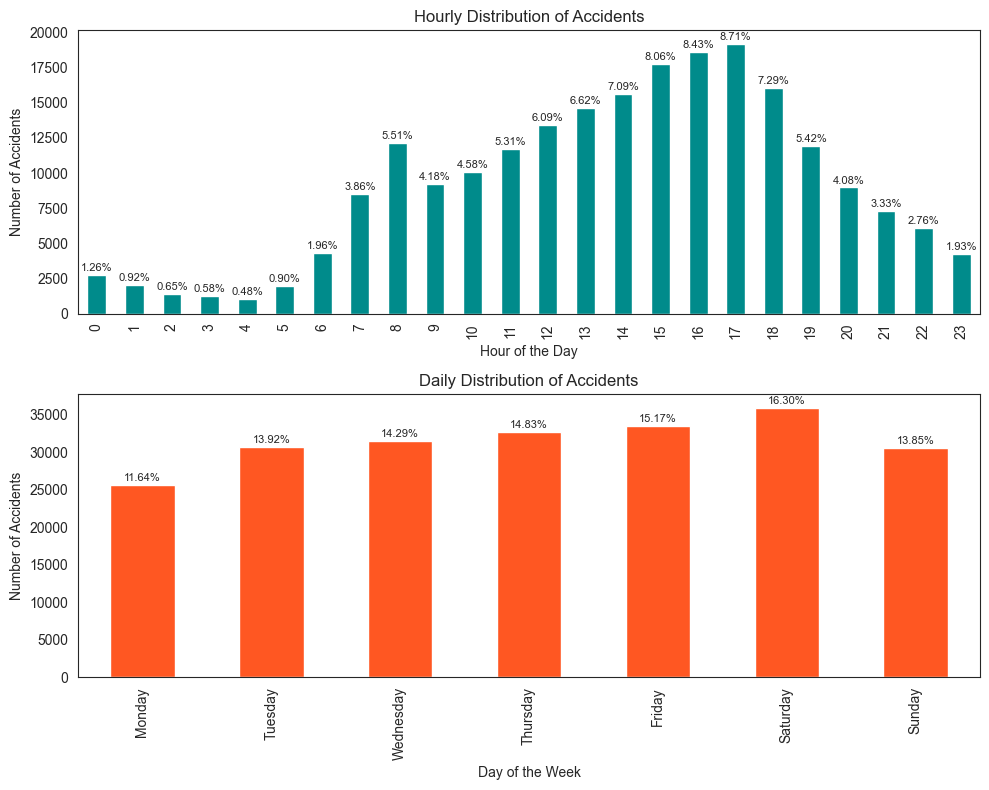

3 Significant hours of the day: 
[17, 16, 15]

3 Significant days of the week: 
[6, 5, 4]


In [91]:
accident_analysis.plot_hourly_and_daily_accidents()

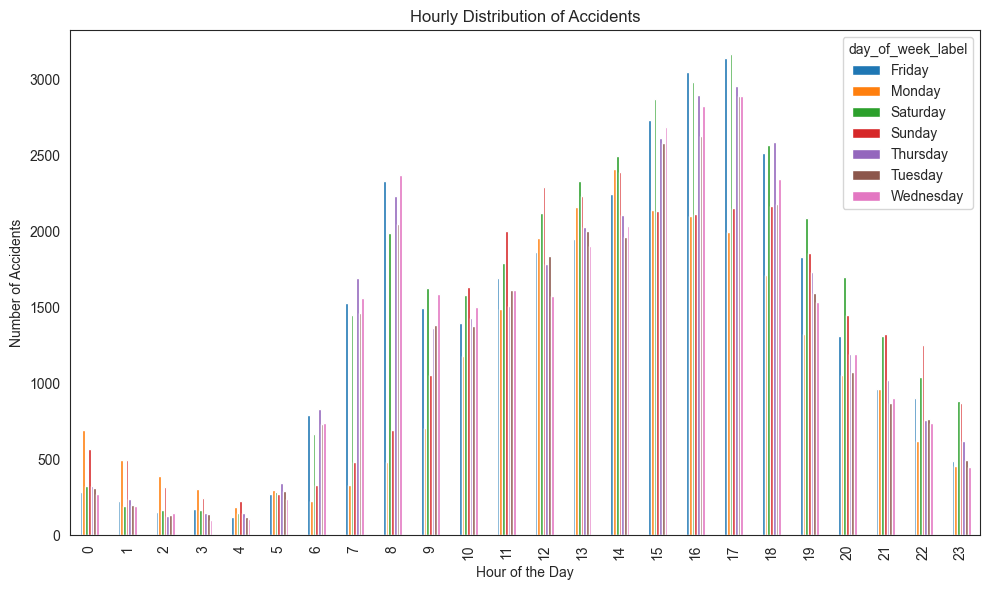

In [92]:
accidents_by_hour_and_day = df.groupby(['hour', 'day_of_week_label']).size().unstack()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Hourly accidents
accidents_by_hour_and_day.plot(kind='bar', stacked=False, ax=ax)
ax.set_title('Hourly Distribution of Accidents')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Number of Accidents')

plt.tight_layout()
plt.show()

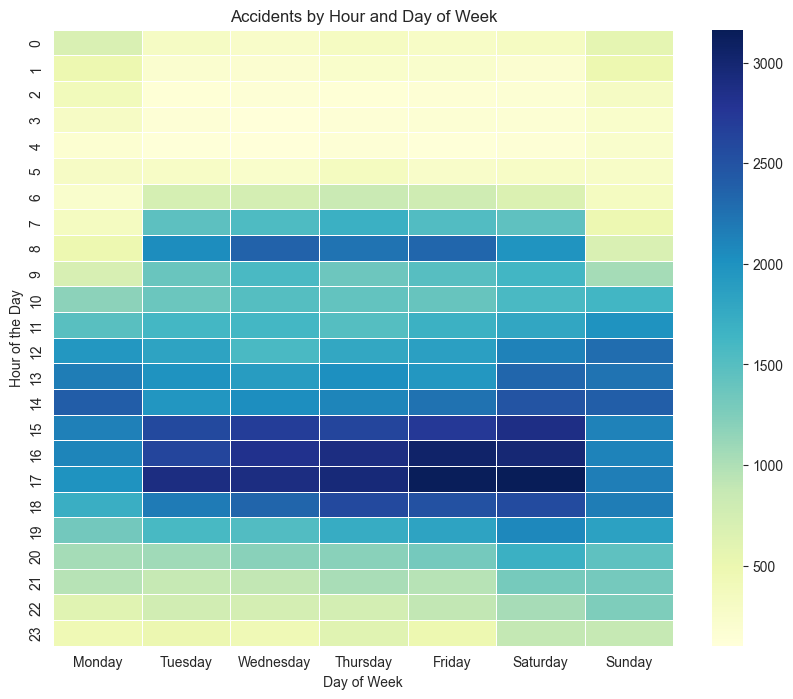

In [93]:
# Define a dictionary to map numerical representations of weekdays to their names
weekday_mapping = {
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
    7: 'Sunday'
}

# Group by hour and day_of_week to get the count
accidents_by_hour_day = df.groupby(['hour', 'day_of_week']).size().unstack()

# Rename the columns using the weekday_mapping dictionary
accidents_by_hour_day.columns = [weekday_mapping[col] for col in accidents_by_hour_day.columns]

# Plotting heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(accidents_by_hour_day, cmap='YlGnBu', linewidths=.5)
plt.title('Accidents by Hour and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour of the Day')
plt.show()

# Part 2: Significant hours and days on which accidents occur for motorbikes

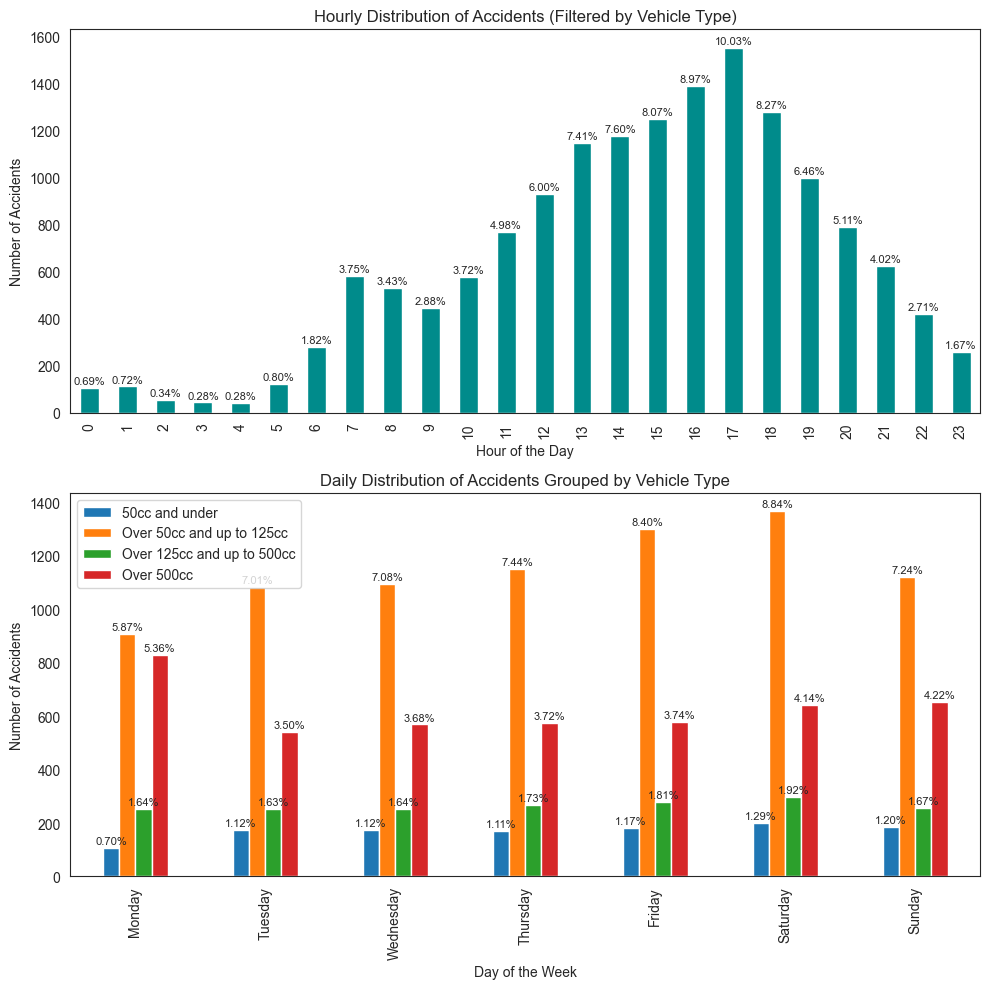

In [94]:
# Motorcycle 50cc and under = 02
# Motorcycle 125cc and under = 03
# Motorcycle over 125cc and up to 500cc = 04
# Motorcycle over 500cc = 05

accident_analysis.plot_hourly_and_daily_accidents_filtered_by_vehicle_type()

In [95]:
# Filter the DataFrame to include only rows where vehicle_type is 2, 3, 4, or 5
df_filtered = df[df['vehicle_type'].isin([2, 3, 4, 5])]

# Group by 'day_of_week' and 'hour' and count the number of accidents
accidents_by_day_hour = df_filtered.groupby(['day_of_week', 'hour']).size()

# Find the most significant hours of the day and days of the week
significant_hours = accidents_by_day_hour.groupby('hour').sum().nlargest(3).index.tolist()
significant_days = accidents_by_day_hour.groupby('day_of_week').sum().nlargest(3).index.tolist()

# Print the results
print(f"3 Significant hours of the day: \n{significant_hours}\n")
print(f"3 Significant days of the week: \n{significant_days}")

3 Significant hours of the day: 
[17, 16, 18]

3 Significant days of the week: 
[6, 5, 7]


# Part 3: Significant hours and days on which accidents occur for pedestrians

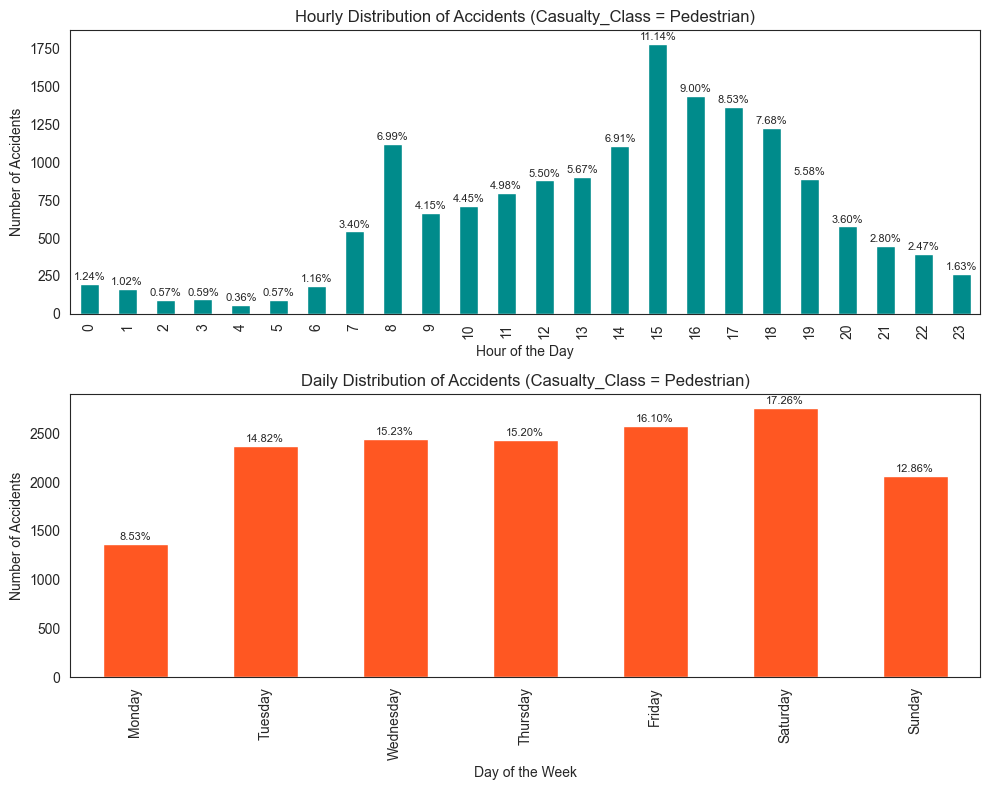

3 Significant hours of the day:
hour
15    1783
16    1441
17    1366
dtype: int64 

3 Significant days of the week: 
day_of_week
6    2764
5    2577
3    2439
dtype: int64
16010


In [96]:
accident_analysis.plot_pedestrian_accidents()

# Part 4: The variable impacts on accident severity using the apriori algorithm

In [97]:
a_severity = pd.get_dummies(df.accident_severity, prefix='severity')
a_severity

,severity_1,severity_2,severity_3
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,1,0
...,...,...,...
220430,0,1,0
220431,0,1,0
220432,0,0,1
220433,0,0,1


In [98]:
a_speed_limit = pd.get_dummies(df.speed_limit, prefix='speed')
a_speed_limit

,speed_20,speed_30,speed_40,speed_50,speed_60,speed_70
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
220430,0,0,0,0,1,0
220431,0,0,0,0,1,0
220432,0,1,0,0,0,0
220433,0,1,0,0,0,0


In [99]:
a_weather_conditions = pd.get_dummies(df.weather_conditions, prefix='weather_conditions')
a_weather_conditions

,weather_conditions_1,weather_conditions_2,weather_conditions_3,weather_conditions_4,weather_conditions_5,weather_conditions_6,weather_conditions_7,weather_conditions_8,weather_conditions_9
0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
220430,1,0,0,0,0,0,0,0,0
220431,1,0,0,0,0,0,0,0,0
220432,1,0,0,0,0,0,0,0,0
220433,1,0,0,0,0,0,0,0,0


In [100]:
a_road_surface_conditions = pd.get_dummies(df.road_surface_conditions, prefix='road_surface_conditions')
a_road_surface_conditions

,road_surface_conditions_-1,road_surface_conditions_1,road_surface_conditions_2,road_surface_conditions_3,road_surface_conditions_4,road_surface_conditions_5,road_surface_conditions_6
0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
220430,0,1,0,0,0,0,0
220431,0,1,0,0,0,0,0
220432,0,1,0,0,0,0,0
220433,0,1,0,0,0,0,0


In [101]:
a_light_conditions = pd.get_dummies(df.light_conditions, prefix='light_conditions')
a_light_conditions

,light_conditions_1,light_conditions_4,light_conditions_5,light_conditions_6,light_conditions_7
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
220430,1,0,0,0,0
220431,1,0,0,0,0
220432,1,0,0,0,0
220433,1,0,0,0,0


In [102]:
a_road_type = pd.get_dummies(df.road_type, prefix='road_type')
a_road_type

,road_type_1,road_type_2,road_type_3,road_type_6,road_type_7,road_type_9
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
220430,0,0,0,1,0,0
220431,0,0,0,1,0,0
220432,0,0,0,1,0,0
220433,0,0,0,1,0,0


In [103]:
df_acc_onehot = pd.concat([a_severity, a_speed_limit, a_weather_conditions, a_road_surface_conditions, a_road_type], axis=1)
df_acc_onehot

,severity_1,severity_2,severity_3,speed_20,speed_30,speed_40,speed_50,speed_60,speed_70,weather_conditions_1,...,road_surface_conditions_3,road_surface_conditions_4,road_surface_conditions_5,road_surface_conditions_6,road_type_1,road_type_2,road_type_3,road_type_6,road_type_7,road_type_9
0,0,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220430,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
220431,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
220432,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
220433,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [104]:
# Running A Priori

frequent_itemsets = apriori(df_acc_onehot.astype(bool), min_support= 0.2, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values('support', ascending = False)
frequent_itemsets

,support,itemsets
3,0.780908,(weather_conditions_1)
1,0.777428,(severity_3)
6,0.720673,(road_type_6)
4,0.688159,(road_surface_conditions_1)
15,0.648554,"(road_surface_conditions_1, weather_conditions_1)"
8,0.604253,"(weather_conditions_1, severity_3)"
16,0.570070,"(weather_conditions_1, road_type_6)"
11,0.549140,"(road_type_6, severity_3)"
2,0.542729,(speed_30)
9,0.536236,"(road_surface_conditions_1, severity_3)"


In [105]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
3,0.780908,(weather_conditions_1),1
1,0.777428,(severity_3),1
6,0.720673,(road_type_6),1
4,0.688159,(road_surface_conditions_1),1
15,0.648554,"(road_surface_conditions_1, weather_conditions_1)",2
8,0.604253,"(weather_conditions_1, severity_3)",2
16,0.570070,"(weather_conditions_1, road_type_6)",2
11,0.549140,"(road_type_6, severity_3)",2
2,0.542729,(speed_30),1
9,0.536236,"(road_surface_conditions_1, severity_3)",2


In [106]:
# Generating Rules

rules = association_rules(frequent_itemsets, metric='lift', min_threshold=0.5)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(road_surface_conditions_1),(weather_conditions_1),0.688159,0.780908,0.648554,0.942448,1.206861,0.111165,3.806832,0.549653
1,(weather_conditions_1),(road_surface_conditions_1),0.780908,0.688159,0.648554,0.830513,1.206861,0.111165,1.839904,0.782340
2,(weather_conditions_1),(severity_3),0.780908,0.777428,0.604253,0.773782,0.995310,-0.002847,0.983882,-0.021054
3,(severity_3),(weather_conditions_1),0.777428,0.780908,0.604253,0.777246,0.995310,-0.002847,0.983559,-0.020732
4,(weather_conditions_1),(road_type_6),0.780908,0.720673,0.570070,0.730009,1.012955,0.007291,1.034579,0.058372
...,...,...,...,...,...,...,...,...,...,...
179,(road_type_6),"(speed_30, road_surface_conditions_1, weather_...",0.720673,0.293846,0.235035,0.326133,1.109877,0.023268,1.047913,0.354420
180,(road_surface_conditions_2),(severity_3),0.294041,0.777428,0.226542,0.770441,0.991013,-0.002054,0.969564,-0.012683
181,(severity_3),(road_surface_conditions_2),0.777428,0.294041,0.226542,0.291399,0.991013,-0.002054,0.996271,-0.039150
182,(road_surface_conditions_2),(road_type_6),0.294041,0.720673,0.209963,0.714059,0.990822,-0.001945,0.976869,-0.012951


In [107]:
#rules[['antecedents','consequents','support','confidence','lift']]

In [108]:
filtered_df_sorted = rules[(rules['consequents'].astype(str).str.contains("(severity_3)")) & (rules['confidence'] >= 0.7)].sort_values(by='lift', ascending=False)
filtered_df_sorted

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
112,"(speed_30, road_surface_conditions_1)","(weather_conditions_1, severity_3)",0.386396,0.604253,0.293846,0.760480,1.258545,0.060365,1.652250,0.334795
160,"(speed_30, road_surface_conditions_1, road_typ...","(weather_conditions_1, severity_3)",0.311759,0.604253,0.235035,0.753900,1.247656,0.046654,1.608076,0.288412
13,(road_surface_conditions_1),"(weather_conditions_1, severity_3)",0.688159,0.604253,0.504099,0.732533,1.212295,0.088277,1.479610,0.561563
54,"(road_surface_conditions_1, road_type_6)","(weather_conditions_1, severity_3)",0.499739,0.604253,0.360901,0.722179,1.195160,0.058932,1.424469,0.326414
24,(speed_30),(severity_3),0.542729,0.777428,0.439268,0.809368,1.041084,0.017335,1.167547,0.086300
82,"(speed_30, road_surface_conditions_1)",(severity_3),0.386396,0.777428,0.312471,0.808682,1.040202,0.012076,1.163361,0.062985
108,"(speed_30, road_surface_conditions_1, weather_...",(severity_3),0.363973,0.777428,0.293846,0.807330,1.038462,0.010883,1.155195,0.058232
76,"(speed_30, weather_conditions_1)",(severity_3),0.428442,0.777428,0.345066,0.805399,1.035978,0.011984,1.143732,0.060761
64,"(speed_30, road_type_6)",(severity_3),0.436899,0.777428,0.348633,0.797971,1.026423,0.008975,1.101680,0.045717
136,"(speed_30, road_surface_conditions_1, road_typ...",(severity_3),0.311759,0.777428,0.248769,0.797954,1.026402,0.006399,1.101587,0.037374


In [109]:
# Adjust display settings to show complete values
pd.set_option('display.max_colwidth', None)

# Display the DataFrame with complete values in the 'consequents' column
print(filtered_df_sorted[['antecedents','consequents','support','confidence','lift']])

                                                                  antecedents  \
112                                     (speed_30, road_surface_conditions_1)   
160                        (speed_30, road_surface_conditions_1, road_type_6)   
13                                                (road_surface_conditions_1)   
54                                   (road_surface_conditions_1, road_type_6)   
24                                                                 (speed_30)   
82                                      (speed_30, road_surface_conditions_1)   
108               (speed_30, road_surface_conditions_1, weather_conditions_1)   
76                                           (speed_30, weather_conditions_1)   
64                                                    (speed_30, road_type_6)   
136                        (speed_30, road_surface_conditions_1, road_type_6)   
152  (speed_30, road_surface_conditions_1, weather_conditions_1, road_type_6)   
122                         

# Part 5: Clustering 

### Defining a class with needed methods

In [110]:
class Claustering:
    def __init__(self, df):
        self.df = df
        
    
    def plot_elbow_diagram(self, locations):
        '''
            The function plots an elbow diagram to find the best cluster number
        '''

        SSE = [] # is the distance of the points from the cluster center
        for k in range(1, 10):
            kmeans = KMeans(n_clusters = k, random_state = 42)
            kmeans.fit(locations)
            intertia = kmeans.inertia_
            SSE.append(intertia)
            
        # plotting the number of clusters
        plot_df = pd.DataFrame({'Cluster' : range(1, 10), 'SSE' : SSE})
        plot_df
        
        plt.plot(plot_df['Cluster'], plot_df['SSE'])
        plt.plot('Cluster', 'SSE', 'b*', data = plot_df)
        plt.xlabel('Cluster', fontsize=20)
        plt.ylabel('SSE', fontsize = 20)
        
    
    def create_kmeans_location_model(self, data, cluster_no):    
        '''
            The function creates kmeans model for location features according to the input cluster_no
        
        '''
        
        kmeans = KMeans(n_clusters = cluster_no)
        X = data[['longitude', 'latitude']]
        kmeans.fit(X)
        
        # Get cluster labels
        clusters = kmeans.predict(X)
        
        # Plot the clusters
        plt.scatter(X['longitude'], X['latitude'], c=clusters, cmap='viridis')
        
        # Plot cluster centroids
        for cluster in set(clusters):
            centroid = kmeans.cluster_centers_[cluster]
            plt.scatter(centroid[0], centroid[1], marker='X', color='red')
        
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()
        
        # intertia for n_clusters
        print(f"inertia for {cluster_no} cluster: {kmeans.inertia_}")
        
        
    def create_kmeans_model(self, data, features, cluster_no):    
        '''
            The method creates kmeans model according to the input features and cluster_no
        
        '''
        print(f"*** Kmeans model for {cluster_no} cluster(s) ***")
        X = data[features]
        kmeans= KMeans(n_clusters=cluster_no)
        kmeans.fit(X)
        clusters = kmeans.predict(X)
        #labels_kmeans= clusters
    
        plt.scatter(X[features[1]], X[features[0]], c=clusters, cmap='rainbow')
    
        for cluster in set(clusters):
            centroid = kmeans.cluster_centers_[cluster]
            plt.scatter(centroid[1], centroid[0], marker='X', color = 'red', s= 50)
        
        plt.xlabel(features[1])
        plt.ylabel(features[0])
        plt.show()
        
        # intertia for n_clusters
        cluster_no_list.append(cluster_no)
        intertia_list.append(kmeans.inertia_)

In [111]:
# Create an instance of the Claustering class
clustering = Claustering(df)

In [112]:
# Filter df for cities, Kingston upon Hull, Humberside, and the East Riding of Yorkshire
df_cities = df[(df['lsoa01nm'].astype(str).str.contains("Kingston upon Hull")) | 
               (df['lsoa01nm'].astype(str).str.contains("Humberside")) |
               (df['lsoa01nm'].astype(str).str.contains("East Riding of Yorkshire")) ]

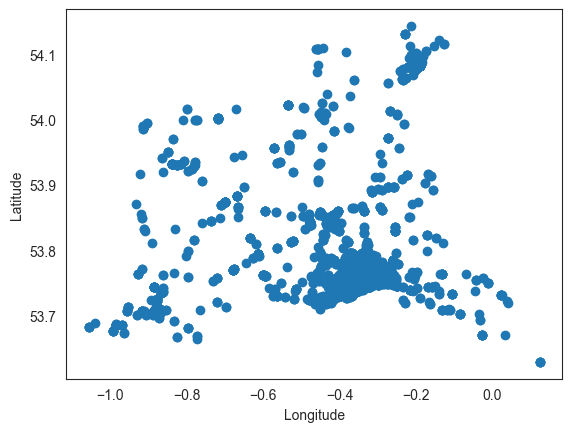

In [113]:
plt.scatter(df_cities['longitude'], df_cities['latitude'])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [114]:
df_cities_location = df_cities[['longitude','latitude']]
df_cities_location

,longitude,latitude
87681,-0.393424,53.744936
87682,-0.393424,53.744936
87684,-0.324858,53.791630
87686,-0.327733,53.767805
87689,-0.309102,53.750410
...,...,...
91736,-0.424674,53.839482
91737,-0.424674,53.839482
91738,-0.308880,53.782750
91743,-0.342063,53.742609


In [115]:
df_cities_location.shape

(2467, 2)

In [116]:
X = np.array(df_cities_location)
X

array([[-0.393424, 53.744936],
       [-0.393424, 53.744936],
       [-0.324858, 53.79163 ],
       ...,
       [-0.30888 , 53.78275 ],
       [-0.342063, 53.742609],
       [-0.342063, 53.742609]])

In [117]:
# preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(df_cities_location)
X, X.shape

(array([[ 0.09221842, -0.57040293],
        [ 0.09221842, -0.57040293],
        [ 0.4483608 , -0.08624677],
        ...,
        [ 0.531353  , -0.17832084],
        [ 0.35899538, -0.5945309 ],
        [ 0.35899538, -0.5945309 ]]),
 (2467, 2))

### Use Kmeans for clustering

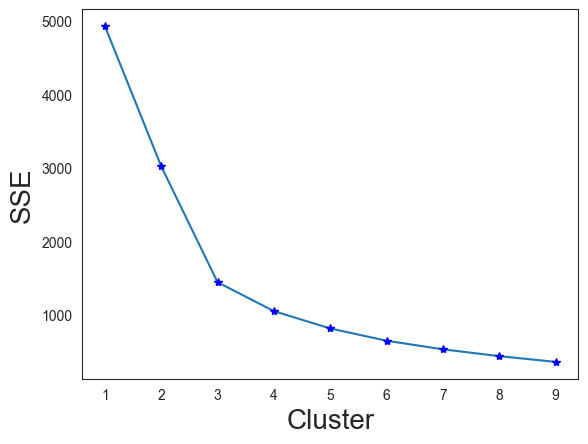

In [118]:
clustering.plot_elbow_diagram(X)

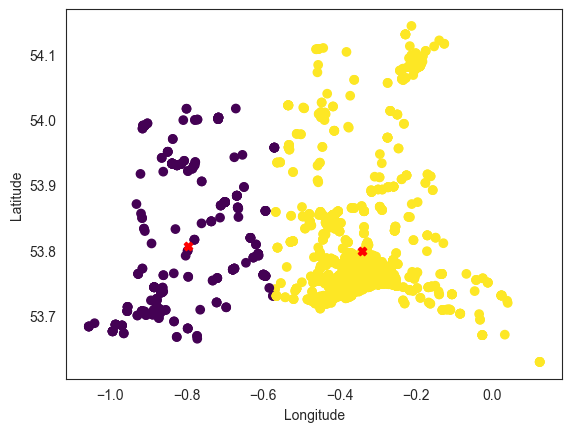

inertia for 2 cluster: 46.76130582892568


In [119]:
clustering.create_kmeans_location_model(df_cities_location, 2)

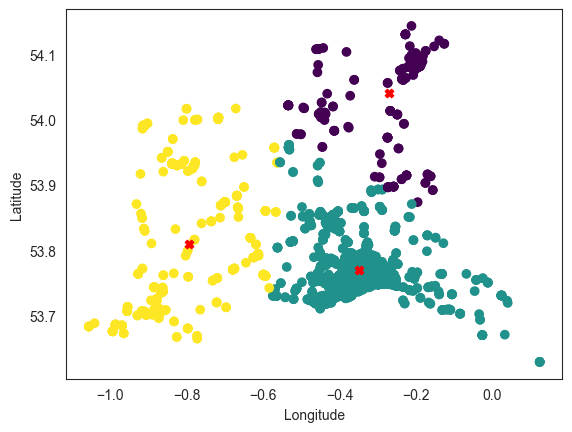

inertia for 3 cluster: 30.825431643496618


In [120]:
clustering.create_kmeans_location_model(df_cities_location, 3)

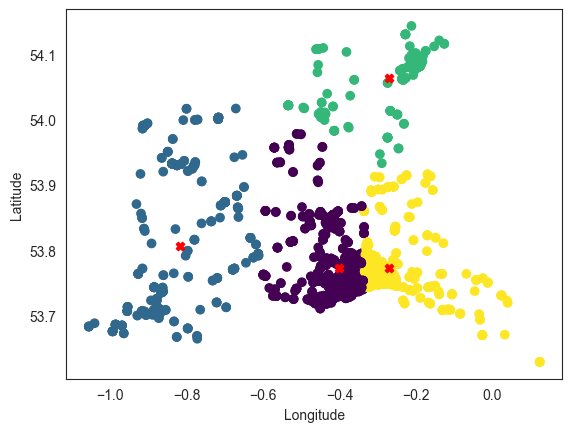

inertia for 4 cluster: 23.493466074671485


In [121]:
clustering.create_kmeans_location_model(df_cities_location, 4)

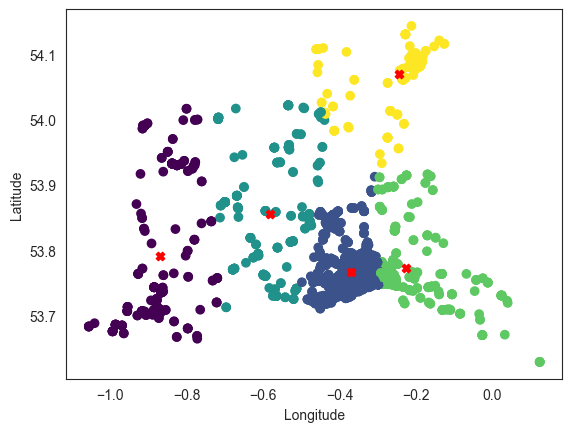

inertia for 5 cluster: 17.461190807701676


In [122]:
clustering.create_kmeans_location_model(df_cities_location, 5)

Text(0, 0.5, 'Intertia')

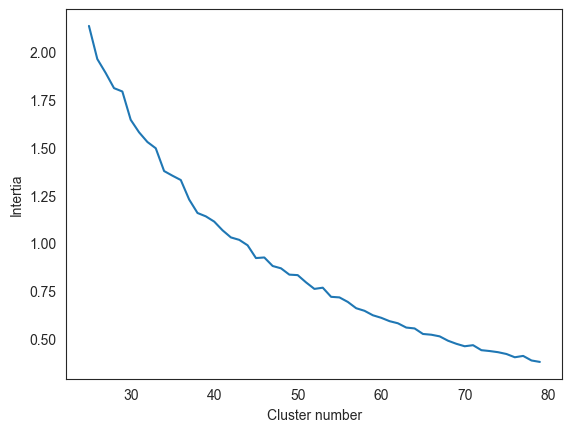

In [123]:
location_features = ['longitude','latitude']

intertia_list = []
X = df_cities_location[location_features]

for k in range (25, 80):
    kmeans= KMeans(n_clusters=k)
    kmeans.fit(X)
    intertia_list.append(kmeans.inertia_)
    
plt.plot(list(range(25, 80)), intertia_list)
plt.xlabel('Cluster number')
plt.ylabel('Intertia')

## More clustering_ faetures 'speed_limit', 'weather_conditions'

In [124]:
feature_list = ['speed_limit', 'weather_conditions']
cluster_no_list = []
intertia_list = []

*** Kmeans model for 5 cluster(s) ***


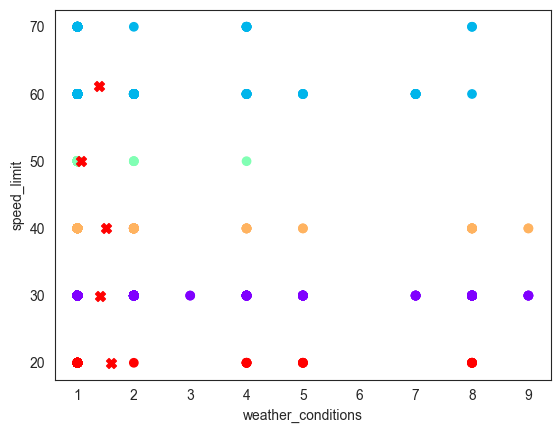

*** Kmeans model for 6 cluster(s) ***


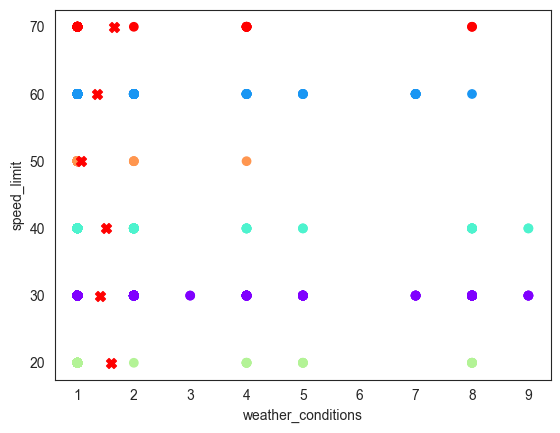

*** Kmeans model for 7 cluster(s) ***


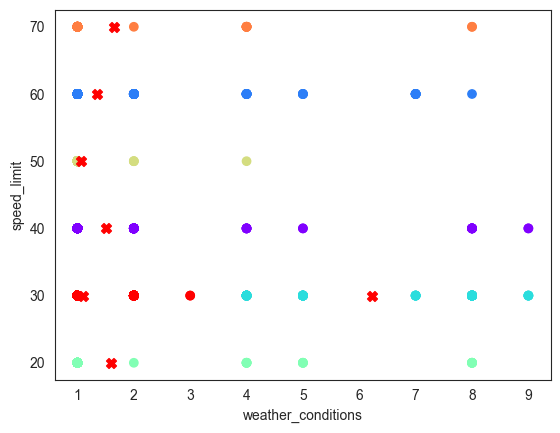

*** Kmeans model for 8 cluster(s) ***


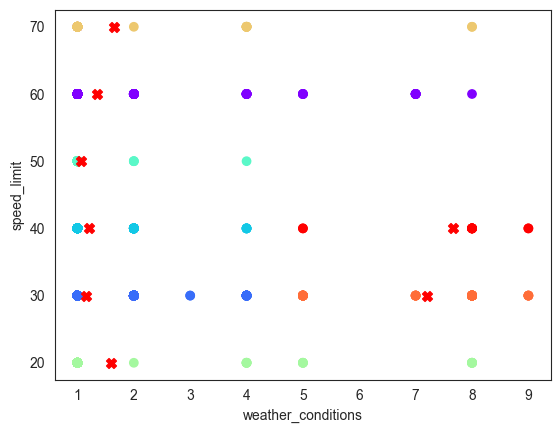

*** Kmeans model for 9 cluster(s) ***


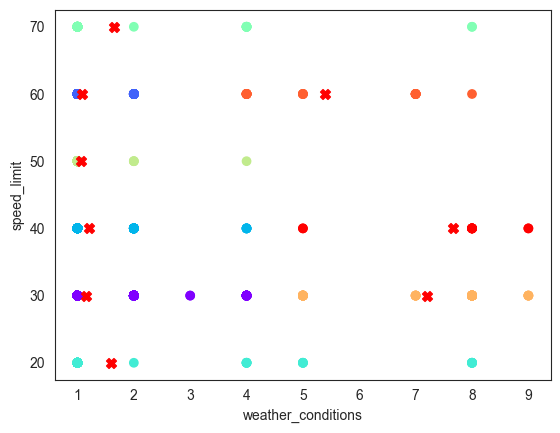

*** Kmeans model for 10 cluster(s) ***


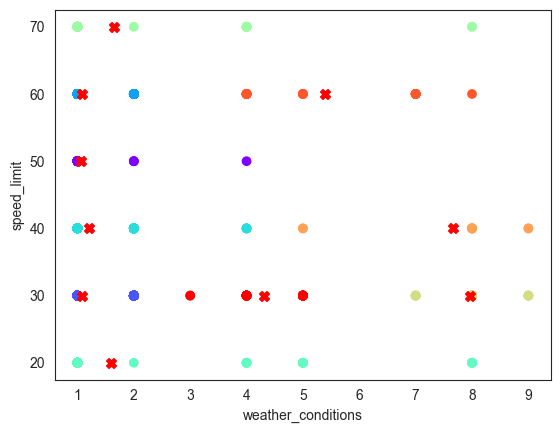

In [125]:
for k in range(5, 11):
    clustering.create_kmeans_model(df_cities, feature_list, k)

In [126]:
df_speed_weather = pd.DataFrame({'Cluster No' : cluster_no_list, 'intertia' : intertia_list})
df_speed_weather

,Cluster No,intertia
0,5,9158.021567
1,6,4247.278638
2,7,1995.110787
3,8,1550.575185
4,9,1149.477309
5,10,819.079490


Text(0, 0.5, 'Intertia')

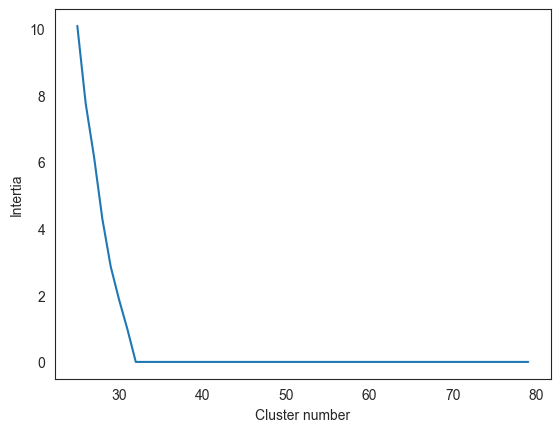

In [127]:
intertia_list = []
X = df_cities[feature_list]

for k in range (25, 80):
    kmeans= KMeans(n_clusters=k)
    kmeans.fit(X)
    intertia_list.append(kmeans.inertia_)
    
plt.plot(list(range(25, 80)), intertia_list)
plt.xlabel('Cluster number')
plt.ylabel('Intertia')

## Using Other Clustering models with K = 25


In [128]:
k = 25
clustering_list=[]
s_score_list=[]

# Memory used
rng = default_rng()
sample_size = min(20000, X.shape[0])
idx = rng.choice(X.shape[0], size=sample_size, replace=False)

# Dataset assignment
X = df_cities[['longitude', 'latitude']]
X_small = X.iloc[idx]
X_small

,longitude,latitude
90865,-0.307062,53.763065
91096,-0.442407,53.824810
88705,-0.340612,53.749403
88076,-0.170232,53.822739
89564,-0.383746,53.770290
...,...,...
91709,-0.318108,53.773648
89638,-0.838287,53.932896
90959,-0.346357,53.746777
88167,-0.326648,53.764958


### K-Means

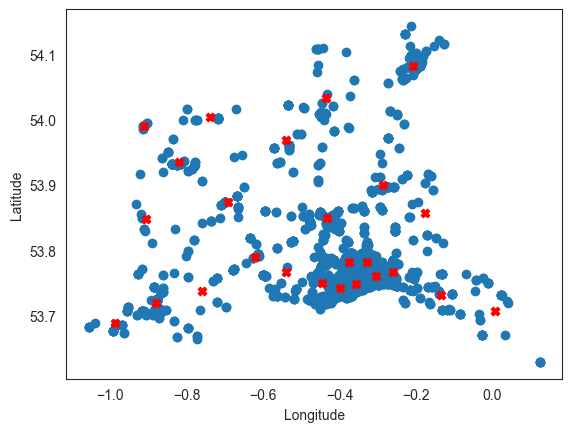

In [129]:
kmeans = KMeans(n_clusters = k)
kmeans.fit(X_small)
    
# Get cluster labels
labels_kmeans = kmeans.predict(X_small)
    
# Plot the clusters
plt.scatter(X_small['longitude'], X_small['latitude'])
    
# Plot cluster centroids
for cluster in set(labels_kmeans):
    centroid = kmeans.cluster_centers_[cluster]
    plt.scatter(centroid[0], centroid[1], marker='X', color='red')
    
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [130]:
s_score = silhouette_score(X_small, labels_kmeans)
print(f"Silhouette_score= {s_score}")

clustering_list.append('K-Means')
s_score_list.append(s_score)

Silhouette_score= 0.46445392886606923


### K-Medoid

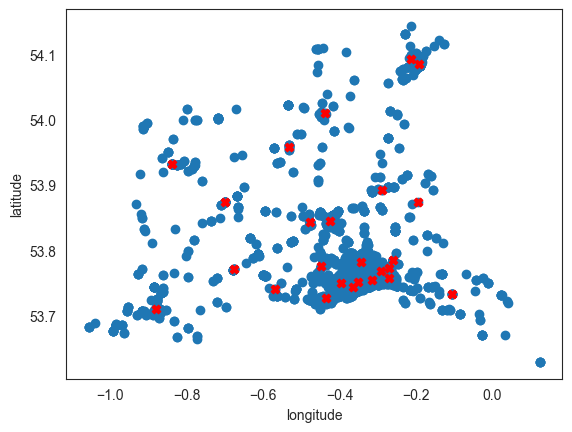

In [131]:
kmedoids = KMedoids(n_clusters=k, init= "random", random_state =5)
kmedoids.fit(X_small)

# Get cluster labels
labels_kmedoids = kmedoids.labels_

# Plot the clusters
plt.scatter(X_small['longitude'], X_small['latitude'])

# Plot cluster centroids
for cluster in set (labels_kmedoids):
    centroid = kmedoids.cluster_centers_[cluster]
    plt.scatter(centroid[0], centroid[1], marker='X', color = 'red')

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [132]:
s_score = silhouette_score(X_small, kmedoids.labels_)
print(f"Silhouette_score= {s_score}")

clustering_list.append('K-Mediod')
s_score_list.append(s_score)

Silhouette_score= 0.35854803347785796


### DBSCAN

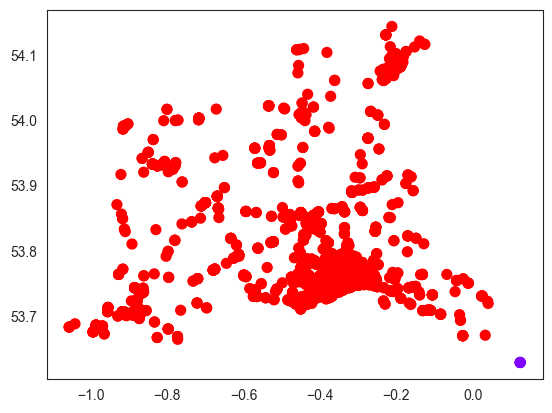

In [133]:
dbscan = DBSCAN(eps= 0.1, min_samples= 5, metric='euclidean')
dbscan.fit(X_small)

# Get cluster labels
labels_dbscan = dbscan.labels_

# plot cluster centroids
fig = plt.figure()
plt.scatter(X_small['longitude'], X_small['latitude'], c = labels_dbscan, cmap='rainbow', s = 50)
plt.show()

In [134]:
s_score = silhouette_score(X_small, labels_dbscan)
print(f"Silhouette_score= {s_score}")

clustering_list.append('DBSCAN')
s_score_list.append(s_score)

Silhouette_score= 0.5873983555821544


In [135]:
# Evaluation

df_clustering_evaluation = pd.DataFrame({'Clustering' : clustering_list, 'Silhouette_Score': s_score_list})
df_clustering_evaluation

,Clustering,Silhouette_Score
0,K-Means,0.464454
1,K-Mediod,0.358548
2,DBSCAN,0.587398


# Part 6: Outlier detection

### Defining a class with needed methods

In [136]:
class OutlierDetection:

    def plot_outliers(self, df, df_outliers, method_name):
        """
            The function plots the outliers on a scatter plot.
        """
        
        plt.scatter(df['longitude'], df['latitude'], c='blue', label='Normal Data', alpha=0.5, s=1)
        plt.scatter(df_outliers['longitude'], df_outliers['latitude'], c='red', label='Anomalies', alpha=0.5, s=0.5)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'Anomalies detected by {method_name}')
        plt.legend()
        plt.grid(True)
        plt.show()

    def calculate_IQR(self, df, df_features):
        """
            The function calculates outliers using Interquartile Range (IQR) method.
        """
        
        q25 = df_features.quantile(0.25)
        q75 = df_features.quantile(0.75)
        iqr = q75 - q25
        lower_bound = q25 - 1.5 * iqr
        upper_bound = q75 + 1.5 * iqr
        iqr_outliers = df_features[((df_features < lower_bound) | (df_features > upper_bound)).any(axis=1)]
        iqr_outliers_location = df.loc[iqr_outliers.index, ['longitude', 'latitude']]
        
        # Plot
        self.plot_outliers(df, iqr_outliers_location, "IQR")

    def calculate_IsolationForest(self, df, df_features):
        """
            The function calculates outliers using Isolation Forest method.
        """
        
        clf_isolation = IsolationForest(contamination=0.1)
        isolation_outliers = clf_isolation.fit_predict(df_features)
        isolation_outliers = df_features[clf_isolation.predict(df_features) == -1]
        isolation_outliers_location = df.loc[isolation_outliers.index, ['longitude', 'latitude']]
        
        # Plot
        self.plot_outliers(df, isolation_outliers_location, "Isolation Forest")

    def calculate_LocalOutlierFactor(self, df, df_features):
        """
            The function calculates outliers using Local Outlier Factor (LOF) method.
        """
        
        clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
        lof_outliers = df_features[clf_lof.fit_predict(df_features) == -1]
        lof_outliers_location = df.loc[lof_outliers.index, ['longitude', 'latitude']]
        
        # Plot
        self.plot_outliers(df, lof_outliers_location, "Local Outlier Factor")

    def calculate_grubbs_test(self, data):
        """
            The function calculates outliers using Grubbs' Test.
        """
        
        avg = data.mean()
        std = data.std()
        absValues = abs(data - avg)
        max = absValues.max()
        G = max/std
        return G

    def get_critical_G(self, size, alpha):
        """
            The function calculates the critical G value for Grubbs' Test.
        """
        
        tdist = t.ppf(1- alpha / (2 * size), size - 2)
        numerator = (size -1) * np.sqrt(np.square(tdist))
        denominator = np.sqrt(size) * np.sqrt(size -2 + np.square(tdist))
        critical_value = numerator / denominator
        print("Grubbs Critical Value: {}".format(critical_value))
        return critical_value

In [137]:
# Create an instance of the OutlierDetection class
outlier_detection = OutlierDetection()

### Apply IQR, IsolationForest, and LocalOutlierFactor on dataset

In [138]:
# Some numerical features are selected for outlier detection
numerical_features = ['age_of_driver', 'age_of_vehicle', 'engine_capacity_cc']
df_features = df[numerical_features]

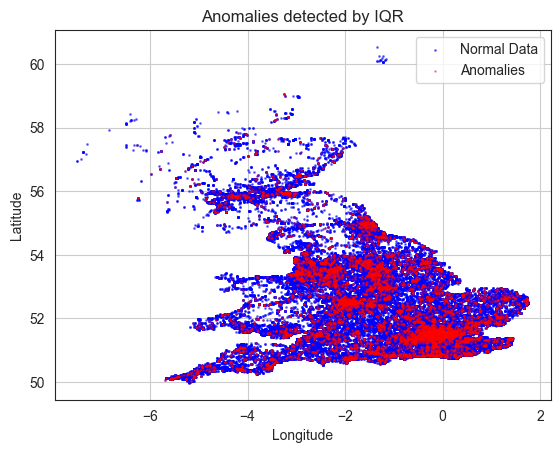

In [139]:
# Apply IQR Test
outlier_detection.calculate_IQR(df, df_features)

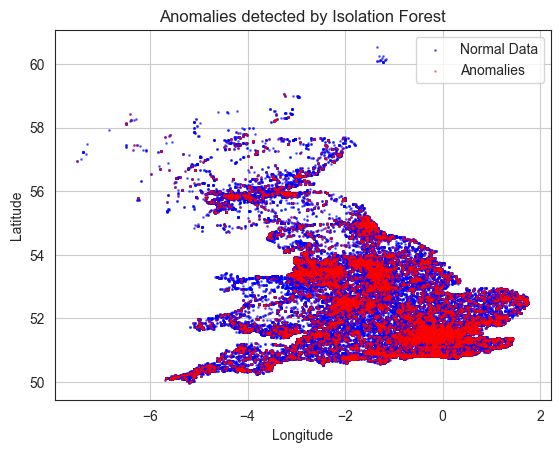

In [140]:
# Apply IsolationForest
outlier_detection.calculate_IsolationForest(df, df_features)

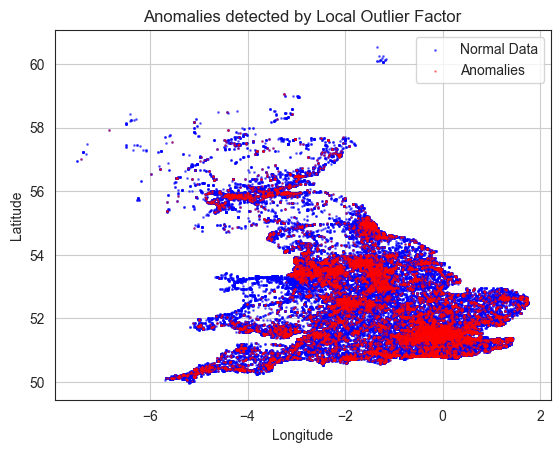

In [141]:
# Apply LocalOutlierFactor
outlier_detection.calculate_LocalOutlierFactor(df, df_features)

### Apply IQR, IsolationForest, and LocalOutlierFactor on Humberside Region

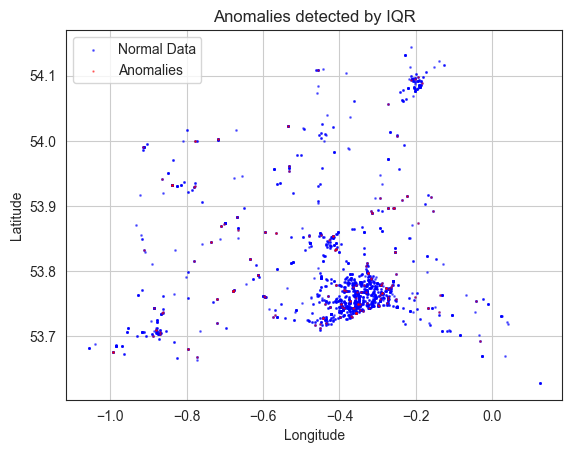

In [142]:
# Apply IQR
df_features = df_cities[numerical_features]
outlier_detection.calculate_IQR(df_cities, df_features)

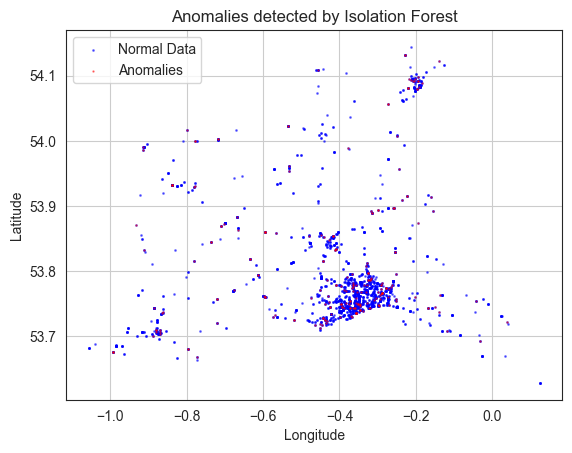

In [143]:
# Apply IsolationForest
df_features = df_cities[numerical_features]
outlier_detection.calculate_IsolationForest(df_cities, df_features)

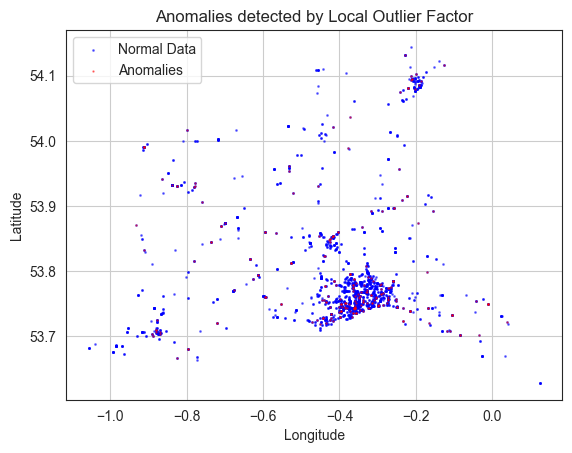

In [144]:
# Apply LocalOutlierFactor
df_features = df_cities[numerical_features]
outlier_detection.calculate_LocalOutlierFactor(df_cities, df_features)

### Using grubbs_test

In [145]:
# age_of_driver
G = outlier_detection.calculate_grubbs_test(df['age_of_driver'])
print(f"G value= {G}")

Gcritical = outlier_detection.get_critical_G(len(df['age_of_driver']), 0.05)

G value= 3.9927666620296263
Grubbs Critical Value: 5.175712135478386


In [146]:
# age_of_vehicle
G = outlier_detection.calculate_grubbs_test(df['age_of_vehicle'])
print(f"G value= {G}")

Gcritical = outlier_detection.get_critical_G(len(df['age_of_vehicle']), 0.05)

G value= 6.622372255382736
Grubbs Critical Value: 5.175712135478386


In [147]:
# engine_capacity_cc
G = outlier_detection.calculate_grubbs_test(df['engine_capacity_cc'])
print(f"G value= {G}")

Gcritical = outlier_detection.get_critical_G(len(df['engine_capacity_cc']), 0.05)

G value= 10.556819644695413
Grubbs Critical Value: 5.175712135478386


# Part 7: Prediction

### Defining a class with needed methods

In [148]:
class Prediction:
    def __init__(self, model_list, accuracy_list, precision_list, recall_list, fscore_list, TPR_list, TNR_list, FPR_list, FNR_list):
        self.model_list = model_list
        self.accuracy_list = accuracy_list
        self.precision_list = precision_list
        self.recall_list = recall_list
        self.fscore_list = fscore_list
        self.TPR_List = TPR_list
        self.TNR_List = TNR_list
        self.FPR_List = FPR_list
        self.FNR_List = FNR_list
    
    
    def get_columns_importance(self, df, columns, n_top_features):    
        '''
            The function shows the importance of the input features and return the top_n_features according to the input
            columns = list<features>
            n_top_features = numerical        
        '''    
        
        # get X and y as feature and target variables    
        X = df[columns]
        y = df['accident_severity']
        
        # balancing the features
        rus = RandomUnderSampler(random_state=42)
        X_balanced, y_balanced = rus.fit_resample(X, y)
        
        # normalization
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_balanced)
        
        # feature selection using Random Forests
        random_forest = RandomForestClassifier(random_state=42)
        random_forest.fit(X_scaled, y_balanced)
        
        # get feature importances from the trained Random Forest
        feature_importances = random_forest.feature_importances_
        
        # get sorted indices
        sorted_indices = np.argsort(feature_importances)    
        
        # sort feature importances
        sorted_feature_importances = feature_importances[sorted_indices]
        sorted_feature_names = X.columns[sorted_indices]    
        
        # plot feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
        plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title('Feature Importance Ranking')
        plt.grid(True)
        plt.show()
        
         # select top_n_features
        list = sorted_feature_names[::-1]
        print("Top", n_top_features, "important features:")
        for feature  in list[: n_top_features] :
            print(feature)        
        return list[: n_top_features]
    
    def get_max_learning_rate(self, X_train, y_train, learning_rates):
        #learning_rates = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
        learning_rate_values = []
    
        for learning_rate in learning_rates:
            gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=20, 
                                                                      learning_rate=learning_rate, 
                                                                      max_features=2, 
                                                                      max_depth=2, 
                                                                      random_state=0)
        
            # Perform cross-validation
            scores = cross_val_score(gradient_boosting_classifier, X_train, y_train, cv=5)
        
            # Print average cross-validation score
            print("Learning rate: ", learning_rate)
            print("Average cross-validation score: {:.3f}".format(scores.mean()))
            learning_rate_values.append("{:.3f}".format(scores.mean()))
            
        df_learning_rates= pd.DataFrame({'learning_rates':learning_rates, 'learning_rate_values':learning_rate_values})
        
        # Get the max learning_rate
        df_learning_rates['learning_rate_values'] = pd.to_numeric(df_learning_rates['learning_rate_values'])
        max_lr_index = df_learning_rates['learning_rate_values'].idxmax()
        max_learning_rate = df_learning_rates.loc[max_lr_index, 'learning_rates']
    
        print("Maximum Learning Rate:", max_learning_rate)
        return max_learning_rate
    
    def create_decision_tree_classifier(self, X_train, y_train):
        # Initialize DecisionTreeClassifier
        dt_clf = DecisionTreeClassifier()
        
        # Train the classifier
        dt_clf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = dt_clf.predict(X_test)
        
        self.get_evaluation(y_test, y_pred)
        self.get_confusion_matrix(y_test, y_pred)        
        model_list.append('DecisionTreeClassifier')
        
        
    def create_gradient_boosting_classifier(self, X_train, y_train, learning_rates):
        # Get the best learning rate
        best_learning_rate = self.get_max_learning_rate(X_train, y_train, learning_rates)

        # Train the final model with the best learning rate selected from above part
        final_classifier = GradientBoostingClassifier(n_estimators=20, learning_rate=best_learning_rate, max_features=2, max_depth=2, random_state=0)
        
        # Train the classifier
        final_classifier.fit(X_train, y_train)
        
        # Make predictions
        y_pred = final_classifier.predict(X_test)
        
        # Evaluate the final model
        self.get_evaluation(y_test, y_pred)
        self.get_confusion_matrix(y_test, y_pred)
        model_list.append('GradientBoostingClassifier')
    
    
    def create_random_forest_classifier(self, X_train, y_train, learning_rates):
        # Initialize RandomForestClassifier
        rf_clf = RandomForestClassifier(random_state=42, bootstrap=False)
        
        # Train the classifier
        rf_clf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = rf_clf.predict(X_test)
        
        # Evaluate the final model
        self.get_evaluation(y_test, y_pred)
        self.get_confusion_matrix(y_test, y_pred)
        model_list.append('RandomForestClassifier')        
        
    
    def using_grid_serachcv(self, classifier_name, X_train, y_train, X_test, y_test):
        # According to the input, the classifier is created
        print(f"The classifier name is {classifier_name}\n")
        
        # Define a parameter grid for hyperparameter tuning
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
            }
        
        try:
            # Initialize a classifier according to the input
            if classifier_name == 'DecisionTreeClassifier':
                model = DecisionTreeClassifier(random_state=42)
            elif classifier_name == 'RandomForestClassifier':
                model = RandomForestClassifier(random_state=42)
            elif classifier_name == 'GradientBoostingClassifier':   
                model = GradientBoostingClassifier(random_state=42)
    
            # Initialize GridSearchCV
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=1)
    
            # Fit the grid search to the data
            grid_search.fit(X_train, y_train)
    
            # Get the best parameters
            best_params = grid_search.best_params_
            print("Best Parameters:", best_params)
    
            # Use the best model to make predictions
            best_rf_clf = grid_search.best_estimator_
            y_pred = best_rf_clf.predict(X_test)
    
            # Evaluate the model
            self.get_evaluation(y_test, y_pred)
            self.get_confusion_matrix(y_test, y_pred)
            
            # Cross-validation scores
            cv_scores = cross_val_score(best_rf_clf, x, y, cv=5, scoring='accuracy')
            print("Cross-Validation Scores:", cv_scores)
            model_list.append(f"{classifier_name} with GridSearchCV")
        except Exception as e:
            print("An error occurred.")
            print(e)
            print(traceback.format_exc())
            
            
    def get_evaluation(self, y_test, y_pred):
        '''
            The function evaluates the accuracy_score, precision_score, recall_score, f1_score for inputes,
            and print all the values along with classification_report
        '''
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_list.append(str(round(accuracy, 2)))
        print(f"Accuracy = {accuracy : .2f}")
    
        # Calculate precision
        precision = precision_score(y_test, y_pred, average='weighted')
        precision_list.append(str(round(precision, 2)))
        print(f"Precision = {precision : .2f}")
    
        # Calculate recall
        recall = recall_score(y_test, y_pred, average='weighted')
        recall_list.append(str(round(recall, 2)))
        print(f"Recall = {recall : .2f}")
        
        # Calculate f1_score
        f_score = f1_score(y_test, y_pred, average='weighted')
        fscore_list.append(str(round(f_score, 2)))
        print(f"F1_score = {f_score : .2f}\n")
        
        # Display the classification reportabs
        print("*** The classification_report ***")
        print(classification_report(y_test, y_pred))
        
        
    def get_confusion_matrix(self, y_test, y_pred):   
        '''
            The fuction plots the Confusion matrix
        '''
        # Plot confusion_matrix
        #display_labels = [0, 1]
        display_labels = ['Not Fatal', 'Fatal']
        con_mat = confusion_matrix(y_test, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=display_labels)
        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(ax=ax, values_format='d')
        #disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
        ax.grid(False)
        plt.show()
        
        # Print the Conclusions on the trained dataset
        TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
        positive_count = TP + FN
        negative_count = FP + TN
        
        TPR = TP / positive_count
        TNR = TN / negative_count
        FPR = FP / negative_count
        FNR = FN / positive_count
        
        # append the result in their specific lists
        TPR_list.append(TPR)
        TNR_list.append(TNR)
        FPR_list.append(FPR)
        FNR_list.append(FNR)        
        
        print("*** The Confusion Matrix Information ***")
        print("The True Positives Rate: {}".format(TPR))
        print("The True Negatives Rate: {}".format(TNR))
        print("The False Positives Rate: {}".format(FPR))
        print("The False Negatives Rate: {}".format(FNR))

In [149]:
accuracy_list=[]
precision_list=[]
recall_list=[]
fscore_list=[]
TPR_list=[]
TNR_list=[]
FPR_list=[]
FNR_list=[]
model_list=[]
balancing_method=[]

In [150]:
# # Create an instance of the Prediction class
prediction = Prediction(model_list, accuracy_list, precision_list, recall_list, fscore_list, TPR_list, TNR_list, FPR_list, FNR_list)

In [151]:
#print(df.info())

## Filter DataFrame to include only columns with int64 or float64 data types
#numeric_columns = df.select_dtypes(include=['int64', 'float64'])

#print(numeric_columns)

In [152]:
#pip install imbalanced-learn

In [153]:
#pip install imbalanced-learn==0.7.0

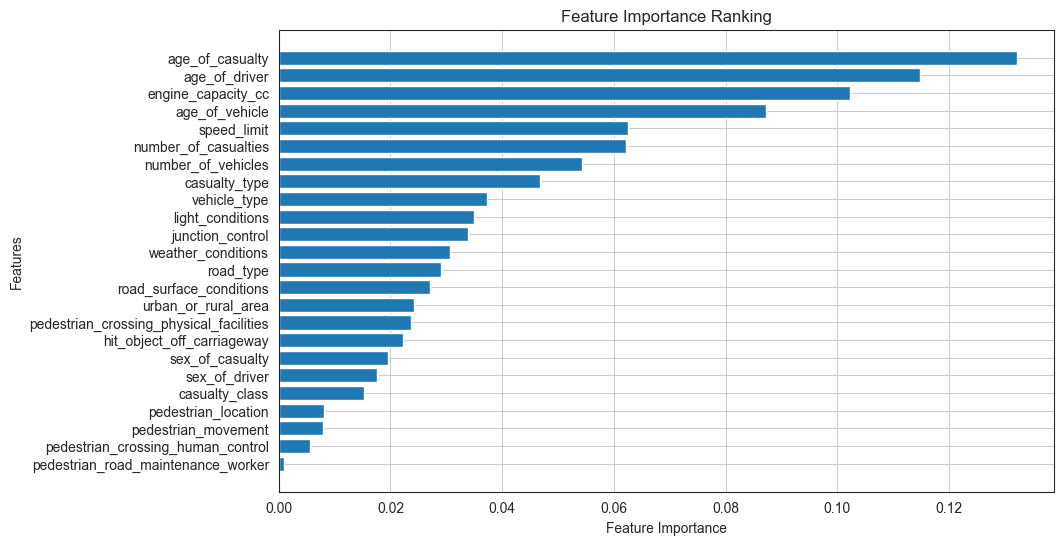

Top 10 important features:
age_of_casualty
age_of_driver
engine_capacity_cc
age_of_vehicle
speed_limit
number_of_casualties
number_of_vehicles
casualty_type
vehicle_type
light_conditions


In [154]:
# select columns with numerical values according to the 'ACCIDENT STATISTICS' page
columns = ['speed_limit',
           'number_of_casualties',
           'number_of_vehicles',
           'urban_or_rural_area',
           'light_conditions',
           'road_type',
           'weather_conditions',
           'pedestrian_crossing_physical_facilities',
           'pedestrian_crossing_human_control',
           'sex_of_casualty',
           'road_surface_conditions',
           'junction_control',
           
           'age_of_casualty',
           'casualty_class',
           'casualty_type',
           'pedestrian_location',
           'pedestrian_movement',
           'pedestrian_road_maintenance_worker',
           
           'engine_capacity_cc',
           'age_of_driver',
           'age_of_vehicle',
           #'vehicle_manoeuvre',
           'vehicle_type',
           'sex_of_driver',
           #'journey_purpose_of_driver',
           #'first_point_of_impact',
           'hit_object_off_carriageway']

features_no = 10

#top_importance_features = get_columns_importance(columns, 10)
top_importance_features = prediction.get_columns_importance(df, columns, features_no)

In [155]:
print(f"The top {features_no} features :\n{list(top_importance_features)}")

The top 10 features :
['age_of_casualty', 'age_of_driver', 'engine_capacity_cc', 'age_of_vehicle', 'speed_limit', 'number_of_casualties', 'number_of_vehicles', 'casualty_type', 'vehicle_type', 'light_conditions']


In [156]:
df['accident_result'] = np.where(df['accident_severity'] == 1, 1, 0)

x = df[top_importance_features]
y = df['accident_result']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Balancing datasets

In [157]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
#balancing_method.append('SMOTE')

In [158]:
# Apply under-sampling to balance the training data
rus = RandomUnderSampler(random_state=42)
X_train_random, y_train_random = rus.fit_resample(X_train, y_train)
#balancing_method.append('Under-sampling')

## Using DecisionTreeClassifier

Accuracy =  0.98
Precision =  0.98
Recall =  0.98
F1_score =  0.98

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43248
           1       0.41      0.46      0.43       833

    accuracy                           0.98     44081
   macro avg       0.70      0.72      0.71     44081
weighted avg       0.98      0.98      0.98     44081



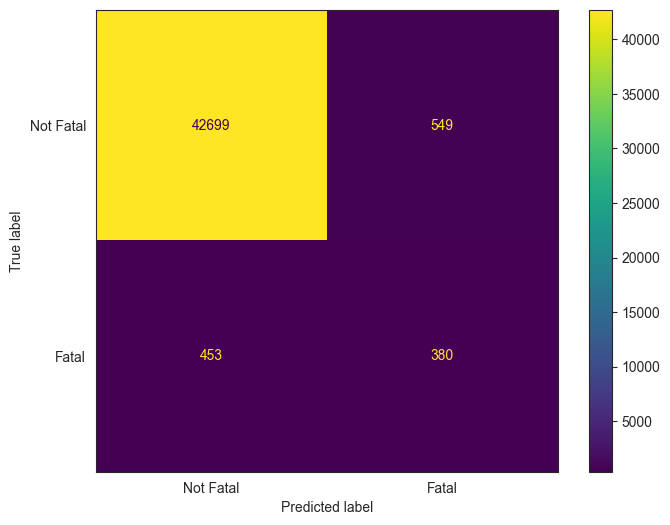

*** The Confusion Matrix Information ***
The True Positives Rate: 0.4561824729891957
The True Negatives Rate: 0.9873057713651499
The False Positives Rate: 0.012694228634850167
The False Negatives Rate: 0.5438175270108043


In [159]:
prediction.create_decision_tree_classifier(X_train, y_train)
balancing_method.append('-')

Accuracy =  0.96
Precision =  0.98
Recall =  0.96
F1_score =  0.96

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     43248
           1       0.21      0.50      0.30       833

    accuracy                           0.96     44081
   macro avg       0.60      0.73      0.64     44081
weighted avg       0.98      0.96      0.96     44081



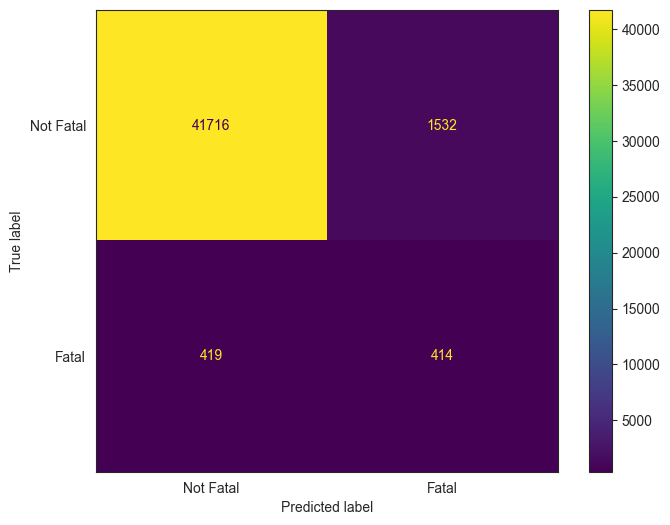

*** The Confusion Matrix Information ***
The True Positives Rate: 0.4969987995198079
The True Negatives Rate: 0.9645763965963744
The False Positives Rate: 0.0354236034036256
The False Negatives Rate: 0.503001200480192


In [160]:
prediction.create_decision_tree_classifier(X_train_smote, y_train_smote)
balancing_method.append('SMOTE')

Accuracy =  0.74
Precision =  0.98
Recall =  0.74
F1_score =  0.83

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     43248
           1       0.05      0.76      0.10       833

    accuracy                           0.74     44081
   macro avg       0.52      0.75      0.47     44081
weighted avg       0.98      0.74      0.83     44081



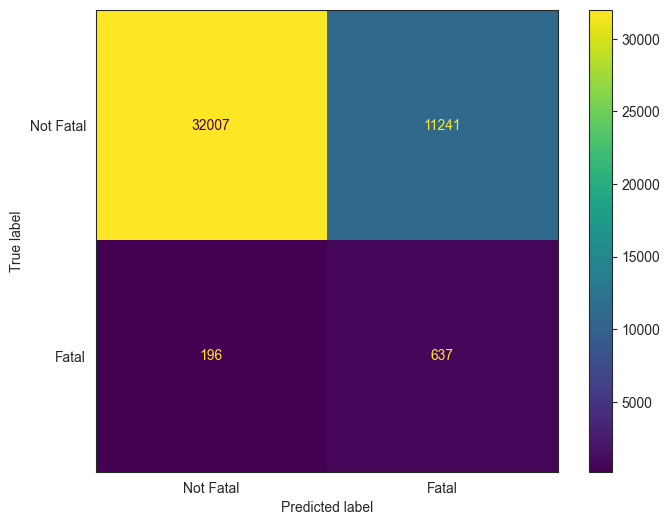

*** The Confusion Matrix Information ***
The True Positives Rate: 0.7647058823529411
The True Negatives Rate: 0.7400804661487237
The False Positives Rate: 0.25991953385127636
The False Negatives Rate: 0.23529411764705882


In [161]:
prediction.create_decision_tree_classifier(X_train_random, y_train_random)
balancing_method.append('Under-Sampling')

## Using GradientBoostingClassifier

In [162]:
learning_rates = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

Learning rate:  0.05
Average cross-validation score: 0.981
Learning rate:  0.075
Average cross-validation score: 0.981
Learning rate:  0.1
Average cross-validation score: 0.981
Learning rate:  0.25
Average cross-validation score: 0.981
Learning rate:  0.5
Average cross-validation score: 0.981
Learning rate:  0.75
Average cross-validation score: 0.979
Learning rate:  1
Average cross-validation score: 0.980
Maximum Learning Rate: 0.05
Accuracy =  0.98
Precision =  0.98
Recall =  0.98
F1_score =  0.97

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     43248
           1       1.00      0.00      0.00       833

    accuracy                           0.98     44081
   macro avg       0.99      0.50      0.50     44081
weighted avg       0.98      0.98      0.97     44081



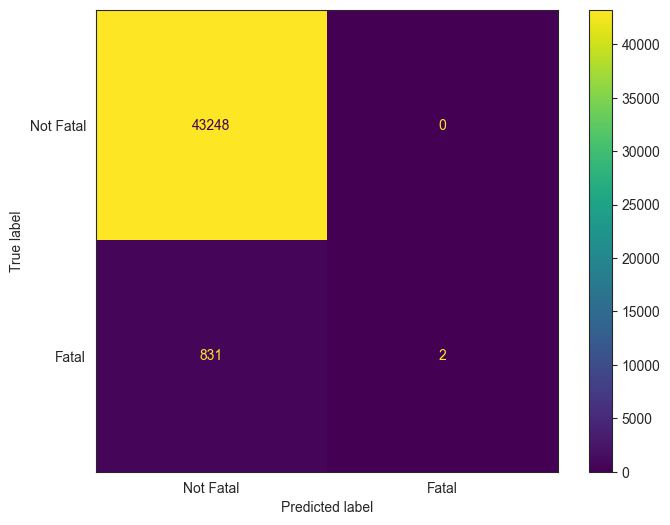

*** The Confusion Matrix Information ***
The True Positives Rate: 0.0024009603841536613
The True Negatives Rate: 1.0
The False Positives Rate: 0.0
The False Negatives Rate: 0.9975990396158463


In [163]:
prediction.create_gradient_boosting_classifier(X_train, y_train, learning_rates)
balancing_method.append('-')

Learning rate:  0.05
Average cross-validation score: 0.769
Learning rate:  0.075
Average cross-validation score: 0.777
Learning rate:  0.1
Average cross-validation score: 0.775
Learning rate:  0.25
Average cross-validation score: 0.795
Learning rate:  0.5
Average cross-validation score: 0.808
Learning rate:  0.75
Average cross-validation score: 0.813
Learning rate:  1
Average cross-validation score: 0.815
Maximum Learning Rate: 1.0
Accuracy =  0.81
Precision =  0.97
Recall =  0.81
F1_score =  0.88

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     43248
           1       0.06      0.63      0.11       833

    accuracy                           0.81     44081
   macro avg       0.53      0.72      0.50     44081
weighted avg       0.97      0.81      0.88     44081



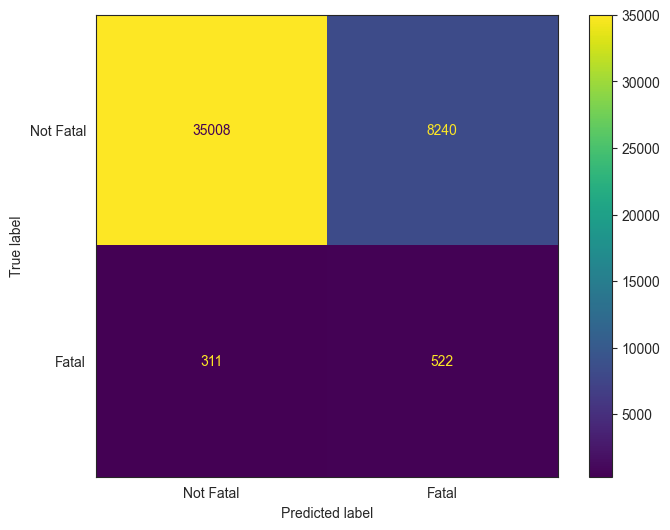

*** The Confusion Matrix Information ***
The True Positives Rate: 0.6266506602641057
The True Negatives Rate: 0.8094709581945986
The False Positives Rate: 0.1905290418054014
The False Negatives Rate: 0.37334933973589435


In [164]:
prediction.create_gradient_boosting_classifier(X_train_smote, y_train_smote, learning_rates)
balancing_method.append('SMOTE')

Learning rate:  0.05
Average cross-validation score: 0.716
Learning rate:  0.075
Average cross-validation score: 0.715
Learning rate:  0.1
Average cross-validation score: 0.719
Learning rate:  0.25
Average cross-validation score: 0.748
Learning rate:  0.5
Average cross-validation score: 0.759
Learning rate:  0.75
Average cross-validation score: 0.762
Learning rate:  1
Average cross-validation score: 0.759
Maximum Learning Rate: 0.75
Accuracy =  0.76
Precision =  0.98
Recall =  0.76
F1_score =  0.84

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     43248
           1       0.06      0.75      0.10       833

    accuracy                           0.76     44081
   macro avg       0.52      0.75      0.48     44081
weighted avg       0.98      0.76      0.84     44081



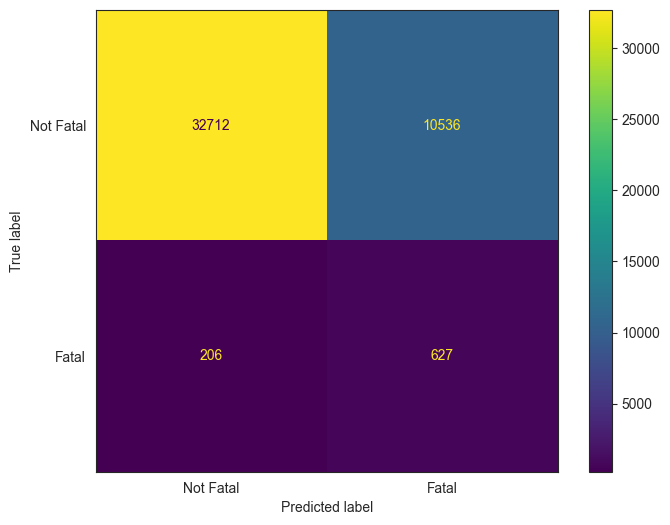

*** The Confusion Matrix Information ***
The True Positives Rate: 0.7527010804321729
The True Negatives Rate: 0.7563817980022197
The False Positives Rate: 0.24361820199778025
The False Negatives Rate: 0.24729891956782712


In [165]:
prediction.create_gradient_boosting_classifier(X_train_random, y_train_random, learning_rates)
balancing_method.append('Under-Sampling')

## Using RandomForestClassifier

Accuracy =  0.99
Precision =  0.99
Recall =  0.99
F1_score =  0.99

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     43248
           1       0.88      0.43      0.58       833

    accuracy                           0.99     44081
   macro avg       0.94      0.71      0.79     44081
weighted avg       0.99      0.99      0.99     44081



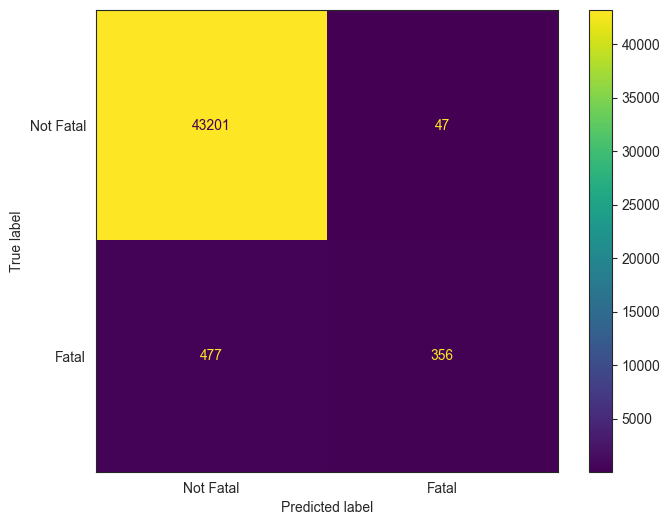

*** The Confusion Matrix Information ***
The True Positives Rate: 0.42737094837935174
The True Negatives Rate: 0.9989132445431003
The False Positives Rate: 0.001086755456899741
The False Negatives Rate: 0.5726290516206483


In [166]:
prediction.create_random_forest_classifier(X_train, y_train, learning_rates)
balancing_method.append('-')

Accuracy =  0.99
Precision =  0.99
Recall =  0.99
F1_score =  0.99

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     43248
           1       0.88      0.43      0.58       833

    accuracy                           0.99     44081
   macro avg       0.94      0.71      0.79     44081
weighted avg       0.99      0.99      0.99     44081



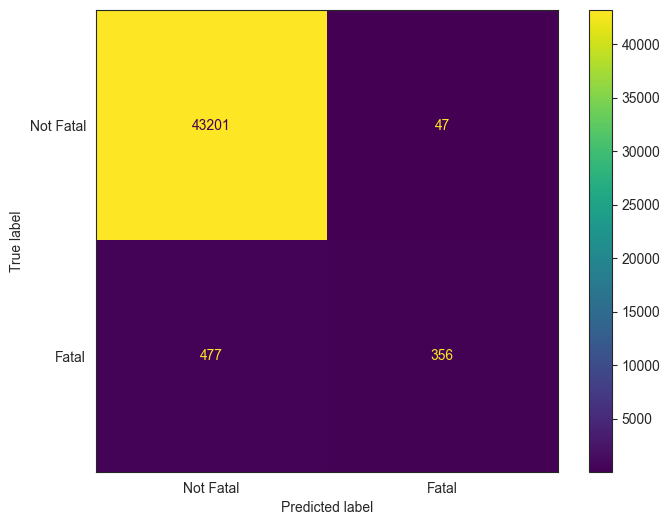

*** The Confusion Matrix Information ***
The True Positives Rate: 0.42737094837935174
The True Negatives Rate: 0.9989132445431003
The False Positives Rate: 0.001086755456899741
The False Negatives Rate: 0.5726290516206483


In [167]:
prediction.create_random_forest_classifier(X_train, y_train, learning_rates)
balancing_method.append('SMOTE')

Accuracy =  0.99
Precision =  0.99
Recall =  0.99
F1_score =  0.99

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     43248
           1       0.88      0.43      0.58       833

    accuracy                           0.99     44081
   macro avg       0.94      0.71      0.79     44081
weighted avg       0.99      0.99      0.99     44081



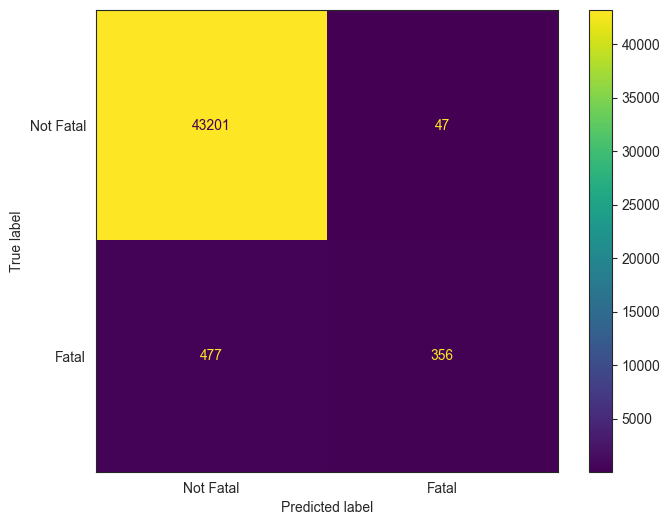

*** The Confusion Matrix Information ***
The True Positives Rate: 0.42737094837935174
The True Negatives Rate: 0.9989132445431003
The False Positives Rate: 0.001086755456899741
The False Negatives Rate: 0.5726290516206483


In [168]:
prediction.create_random_forest_classifier(X_train, y_train, learning_rates)
balancing_method.append('Under-Sampling')

In [169]:
# Create a dataframe to show all the dataset balancing results
df_balancing_dataset = pd.DataFrame({'Model': model_list,
                                     'Balancing Method': balancing_method,
                                     'Accuracy': accuracy_list,
                                     'Precision': precision_list,
                                     'Recall' : recall_list,
                                     'F1': fscore_list,
                                     'TP Rate': TPR_list,
                                     'TN Rate': TNR_list,
                                     'FP Rate': FPR_list,
                                     'FN Rate': FNR_list
                                    })
df_balancing_dataset

,Model,Balancing Method,Accuracy,Precision,Recall,F1,TP Rate,TN Rate,FP Rate,FN Rate
0,DecisionTreeClassifier,-,0.98,0.98,0.98,0.98,0.456182,0.987306,0.012694,0.543818
1,DecisionTreeClassifier,SMOTE,0.96,0.98,0.96,0.96,0.496999,0.964576,0.035424,0.503001
2,DecisionTreeClassifier,Under-Sampling,0.74,0.98,0.74,0.83,0.764706,0.740080,0.259920,0.235294
3,GradientBoostingClassifier,-,0.98,0.98,0.98,0.97,0.002401,1.000000,0.000000,0.997599
4,GradientBoostingClassifier,SMOTE,0.81,0.97,0.81,0.88,0.626651,0.809471,0.190529,0.373349
5,GradientBoostingClassifier,Under-Sampling,0.76,0.98,0.76,0.84,0.752701,0.756382,0.243618,0.247299
6,RandomForestClassifier,-,0.99,0.99,0.99,0.99,0.427371,0.998913,0.001087,0.572629
7,RandomForestClassifier,SMOTE,0.99,0.99,0.99,0.99,0.427371,0.998913,0.001087,0.572629
8,RandomForestClassifier,Under-Sampling,0.99,0.99,0.99,0.99,0.427371,0.998913,0.001087,0.572629


Balancing Evaluation
Based on these results, it appears that SMOTE generally performs better than under-sampling. 
Models trained with SMOTE tend to have higher accuracy, precision, recall, and F1 score compared to models trained 
with under-sampling. Therefore, SMOTE seems to be the better balancing method in this scenario.

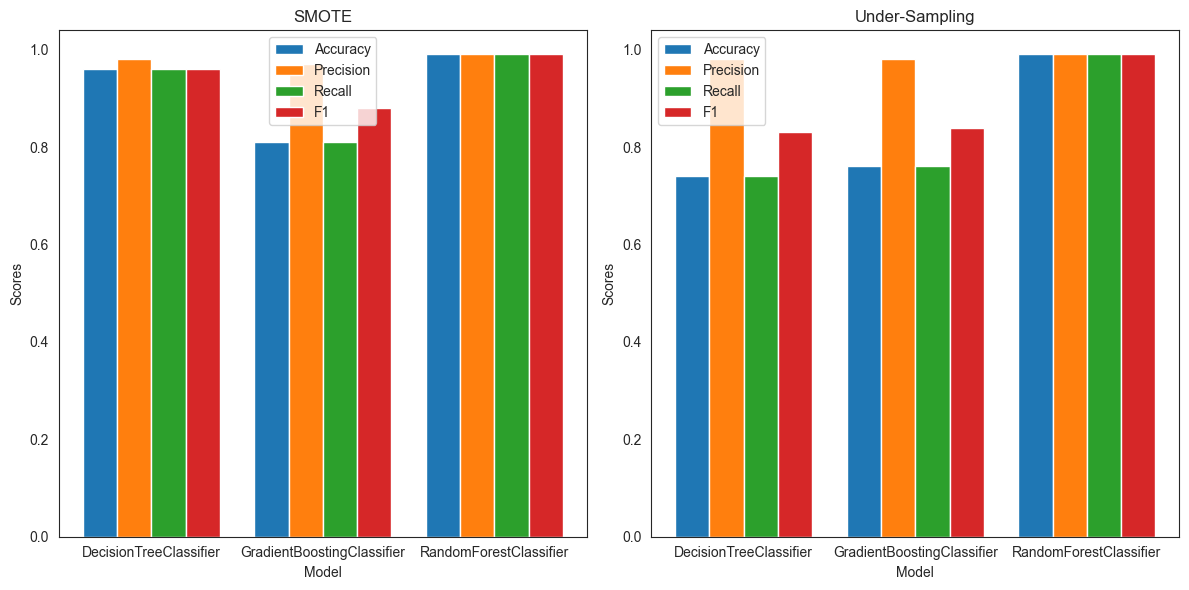

In [170]:
# Pltting Data
# Data for SMOTE
df_SMOTE = df_balancing_dataset[df_balancing_dataset['Balancing Method'] == 'SMOTE']
models_SMOTE = df_SMOTE['Model'].unique()
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

# Initialize an empty array to store the data for SMOTE
data_SMOTE = np.zeros((len(models_SMOTE), len(metrics)))

# Fill the data array with the corresponding values from the DataFrame for SMOTE
for i, model in enumerate(models_SMOTE):
    for j, metric in enumerate(metrics):
        value = df_SMOTE.loc[df_SMOTE['Model'] == model, metric].values[0]
        data_SMOTE[i, j] = value

# Data for Under-Sampling
df_UnderSampling = df_balancing_dataset[df_balancing_dataset['Balancing Method'] == 'Under-Sampling']
models_UnderSampling = df_UnderSampling['Model'].unique()

# Initialize an empty array to store the data for Under-Sampling
data_UnderSampling = np.zeros((len(models_UnderSampling), len(metrics)))

# Fill the data array with the corresponding values from the DataFrame for Under-Sampling
for i, model in enumerate(models_UnderSampling):
    for j, metric in enumerate(metrics):
        value = df_UnderSampling.loc[df_UnderSampling['Model'] == model, metric].values[0]
        data_UnderSampling[i, j] = value

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create subplots with 1 row and 2 columns

# Plot for SMOTE
index = np.arange(len(models_SMOTE))
bar_width = 0.2

axs[0].set_title('SMOTE')
for i, metric in enumerate(metrics):
    axs[0].bar(index + i * bar_width, data_SMOTE[:, i], bar_width, label=metric)

axs[0].set_xlabel('Model')
axs[0].set_ylabel('Scores')
axs[0].set_xticks(index + 1.5 * bar_width)
axs[0].set_xticklabels(models_SMOTE)
axs[0].legend()

# Plot for Under-Sampling
axs[1].set_title('Under-Sampling')
for i, metric in enumerate(metrics):
    axs[1].bar(index + i * bar_width, data_UnderSampling[:, i], bar_width, label=metric)

axs[1].set_xlabel('Model')
axs[1].set_ylabel('Scores')
axs[1].set_xticks(index + 1.5 * bar_width)
axs[1].set_xticklabels(models_UnderSampling)
axs[1].legend()

plt.tight_layout()
plt.show()

## Using DecisionTreeClassifier with GridSearchCV

The classifier name is DecisionTreeClassifier

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy =  0.98
Precision =  0.98
Recall =  0.98
F1_score =  0.98

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     43248
           1       0.75      0.14      0.23       833

    accuracy                           0.98     44081
   macro avg       0.87      0.57      0.61     44081
weighted avg       0.98      0.98      0.98     44081



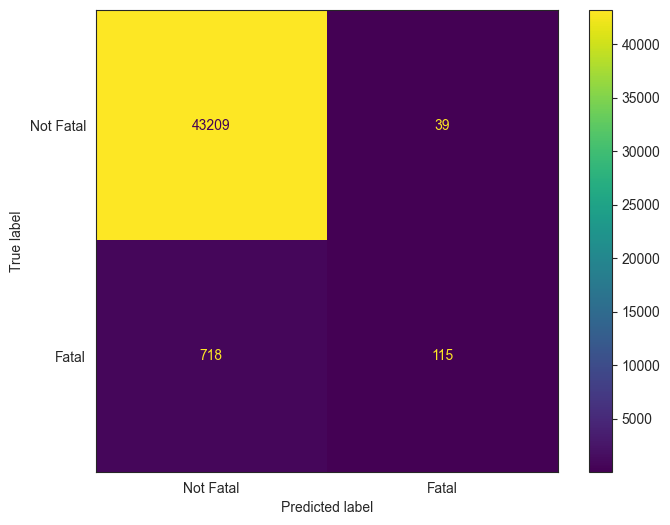

*** The Confusion Matrix Information ***
The True Positives Rate: 0.13805522208883553
The True Negatives Rate: 0.9990982241953386
The False Positives Rate: 0.0009017758046614872
The False Negatives Rate: 0.8619447779111644
Cross-Validation Scores: [0.98015018 0.97853902 0.97758621 0.97749546 0.9777677 ]


In [171]:
prediction.using_grid_serachcv('DecisionTreeClassifier', X_train, y_train, X_test, y_test)
balancing_method.append('-')
#model_list.append(f"RandomForest with GridSearchCV")

## Using RandomForest with GridSearchCV

The classifier name is RandomForestClassifier

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy =  0.99
Precision =  0.99
Recall =  0.99
F1_score =  0.98

*** The classification_report ***
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     43248
           1       0.94      0.33      0.49       833

    accuracy                           0.99     44081
   macro avg       0.96      0.67      0.74     44081
weighted avg       0.99      0.99      0.98     44081



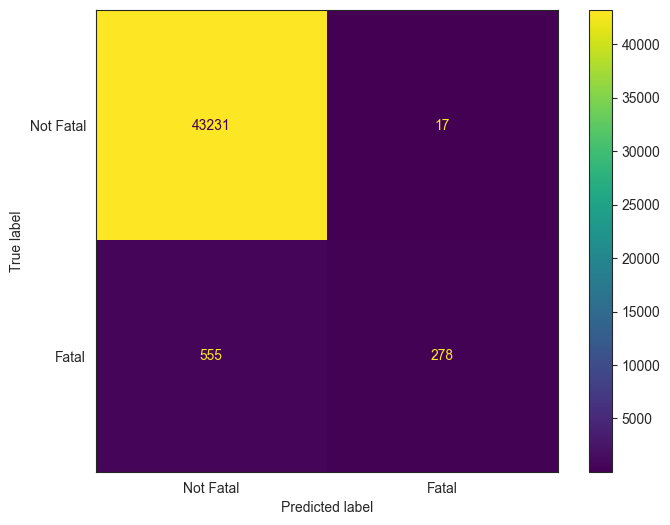

*** The Confusion Matrix Information ***
The True Positives Rate: 0.33373349339735897
The True Negatives Rate: 0.9996069182389937
The False Positives Rate: 0.00039308176100628933
The False Negatives Rate: 0.6662665066026411
Cross-Validation Scores: [0.9808988  0.98078494 0.9801951  0.9790608  0.97801724]


In [172]:
prediction.using_grid_serachcv('RandomForestClassifier', X_train, y_train, X_test, y_test)
balancing_method.append('-')

In [174]:
# Create a dataframe to show all the dataset balancing results
df_balancing_dataset = pd.DataFrame({'Model': model_list,
                                     'Balancing Method': balancing_method,
                                     'Accuracy': accuracy_list,
                                     'Precision': precision_list,
                                     'Recall' : recall_list,
                                     'F1': fscore_list,
                                     'TP Rate': TPR_list,
                                     'TN Rate': TNR_list,
                                     'FP Rate': FPR_list,
                                     'FN Rate': FNR_list
                                    })
df_balancing_dataset

,Model,Balancing Method,Accuracy,Precision,Recall,F1,TP Rate,TN Rate,FP Rate,FN Rate
0,DecisionTreeClassifier,-,0.98,0.98,0.98,0.98,0.456182,0.987306,0.012694,0.543818
1,DecisionTreeClassifier,SMOTE,0.96,0.98,0.96,0.96,0.496999,0.964576,0.035424,0.503001
2,DecisionTreeClassifier,Under-Sampling,0.74,0.98,0.74,0.83,0.764706,0.740080,0.259920,0.235294
3,GradientBoostingClassifier,-,0.98,0.98,0.98,0.97,0.002401,1.000000,0.000000,0.997599
4,GradientBoostingClassifier,SMOTE,0.81,0.97,0.81,0.88,0.626651,0.809471,0.190529,0.373349
5,GradientBoostingClassifier,Under-Sampling,0.76,0.98,0.76,0.84,0.752701,0.756382,0.243618,0.247299
6,RandomForestClassifier,-,0.99,0.99,0.99,0.99,0.427371,0.998913,0.001087,0.572629
7,RandomForestClassifier,SMOTE,0.99,0.99,0.99,0.99,0.427371,0.998913,0.001087,0.572629
8,RandomForestClassifier,Under-Sampling,0.99,0.99,0.99,0.99,0.427371,0.998913,0.001087,0.572629
9,DecisionTreeClassifier with GridSearchCV,-,0.98,0.98,0.98,0.98,0.138055,0.999098,0.000902,0.861945


## Analysis:

Decision Tree vs. Gradient Boosting vs. Random Forest:
Random Forest generally performs better than Decision Tree and Gradient Boosting in terms of TP Rate, TN Rate, and FP Rate, regardless of the balancing method used.
Decision Tree and Gradient Boosting show lower TP Rates and higher FN Rates compared to Random Forest.

Effect of Balancing Methods:
Balancing methods like SMOTE and Under-Sampling improve TP Rate and balance FP and FN Rates compared to no balancing, especially for Decision Tree and Gradient Boosting models.
However, there's a trade-off, as SMOTE and Under-Sampling may slightly decrease TN Rates.

GridSearchCV:
GridSearchCV does not significantly improve the performance in terms of TP Rate, TN Rate, FP Rate, or FN Rate compared to the base models.
Conclusion:

Based on the provided metrics, Random Forest Classifier with or without balancing methods generally performs better in terms of TP Rate, TN Rate, FP Rate, and FN Rate compared to Decision Tree and Gradient Boosting classifiers. If you prioritize balanced performance, Random Forest with SMOTE or Under-Sampling could be a good choice.

In [ ]:
cur.close()
con.close()

In [ ]:
# pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
